## Loading Data from Kaggle

### Setup Kaggle API Key (Not executed)

In [ ]:
!pip3 install kaggle

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json

kaggle_username = "dlakshma"
kaggle_key = "Masked"

# Save API token the kaggle.json file
with open("./kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download dataset from Kaggle

In [19]:
# Download and unzip the dataset
!kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format

100%|█████████████████████████████████████▉| 4.07G/4.07G [12:40<00:00, 32.9MB/s]
100%|██████████████████████████████████████| 4.07G/4.07G [12:40<00:00, 5.75MB/s]


In [23]:
# Create Data folder to store the extracted files from downloaded zip
!mkdir -p ./Data

In [22]:
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o amex-data-integer-dtypes-parquet-format.zip -d ./Data

Archive:  amex-data-integer-dtypes-parquet-format.zip
  inflating: ./Data/test.parquet     
  inflating: ./Data/train.parquet    


## Create Pandas Dataframe and Explore dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
x_train_parquet = pd.read_parquet(f"./Data/train.parquet")
print(f"x_train_parquet dimensions: {x_train_parquet.shape}")

x_train_parquet dimensions: (5531451, 190)


In [6]:
y_train = pd.read_csv(f"./Data/train_labels.csv")
print("Train label size:", y_train.shape)

Train label size: (458913, 2)


In [7]:
x_train_parquet_target = pd.merge(x_train_parquet, y_train, how='left', on = 'customer_ID')

In [8]:
print(x_train_parquet_target['target'].value_counts())

0    4153582
1    1377869
Name: target, dtype: int64


Since dataset is huge performing minimal EDA using Pandas profiler

In [9]:
large_dataset = x_train_parquet_target.copy(deep=True)

In [ ]:
import sys
!{sys.executable} -m pip install -U ydata-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(large_dataset, minimal=True)
profile.to_file("minimal_EDA.html")

Out of 191 columns in the dataset, alerts are raised for 169 columns for one of the below reasons:
1. Too many zeros 
2. Too much missing data
3. Highly skewed data
4. High cardinality

Instead of dropping all columns, histogram plots are used in below steps in the section to better understand the data in the columns and retain the ones that can be informative for the model.

### ----Too many zeros----

Some categorical columns are listed under too many zeros. Zero can be one of the few categories for such variables so it is important to explore the categorical columns further and retain the ones which contains significant information.

In [30]:
# List categorical columns as defined in the Kaggle challenge -> Data section
category_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [212]:
for col in category_cols:
    print(f"{col} :{large_dataset[col].unique()} --> {len(large_dataset[col].unique())} distinct values")

B_30 :[ 0  2  1 -1] --> 4 distinct values
B_38 :[ 2  1  3  5  6  7  4 -1] --> 8 distinct values
D_114 :[ 1  0 -1] --> 3 distinct values
D_116 :[ 0 -1  1] --> 3 distinct values
D_117 :[ 5  0  7  3  2 -1  4  6] --> 8 distinct values
D_120 :[ 0  1 -1] --> 3 distinct values
D_126 :[ 2 -1  1  0] --> 4 distinct values
D_63 :[0 3 4 1 2 5] --> 6 distinct values
D_64 :[ 0  2 -1  3  1] --> 5 distinct values
D_66 :[-1  1  0] --> 3 distinct values
D_68 :[ 6  2  3 -1  5  4  0  1] --> 8 distinct values


As seen above 0 is a category for some of the variables.

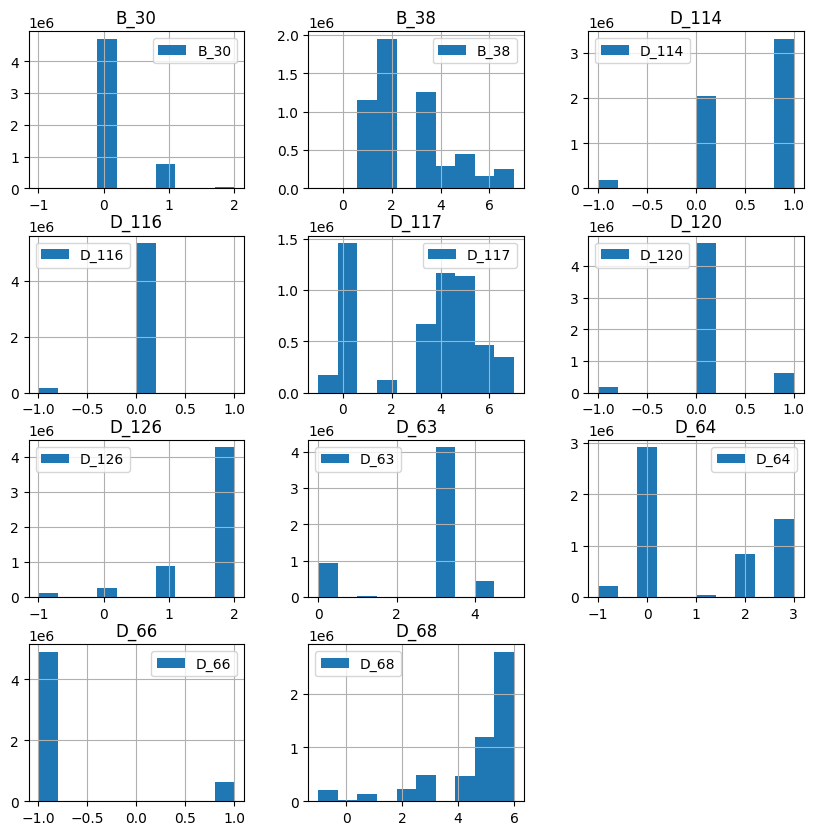

In [38]:
# Histogram to visualize the frequency of data in categorical columns
large_dataset.hist(column=category_cols, figsize=(10, 10), legend=True);

Building histogram for each categorical column grouped by target value i.e. 0 (non-defaulter) and 1 (defaulter) to see if there is any variance see in the category based of target type.

In [101]:
from matplotlib.ticker import PercentFormatter

def plot_histogram_grouped_by_target(df, columns):
    large_dataset_defaulters = df[(df.target == 1)]
    large_dataset_nondefaulters = df[(df.target == 0)]
    for col in columns:
        fig, axs = plt.subplots(1, 2, constrained_layout = True, sharey=True)
        plt.subplot(1, 2, 1)
        data = large_dataset_defaulters[col]
        axs[0].hist(data, edgecolor='black', weights=np.ones_like(data)*100 / len(data));
        axs[0].yaxis.set_major_formatter(PercentFormatter());
        plt.title('Defaulters '+col);

        plt.subplot(1, 2, 2)
        data = large_dataset_nondefaulters[col]
        axs[1].hist(data, edgecolor='black', weights=np.ones_like(data)*100 / len(data));
        axs[1].yaxis.set_major_formatter(PercentFormatter());
        plt.title('Non Defaulters '+col);

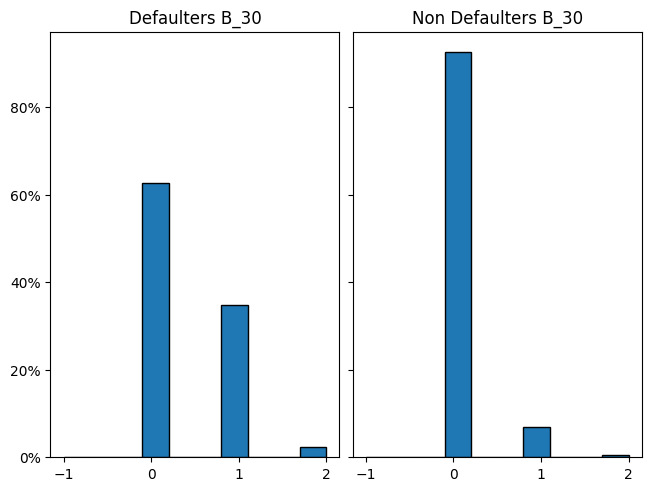

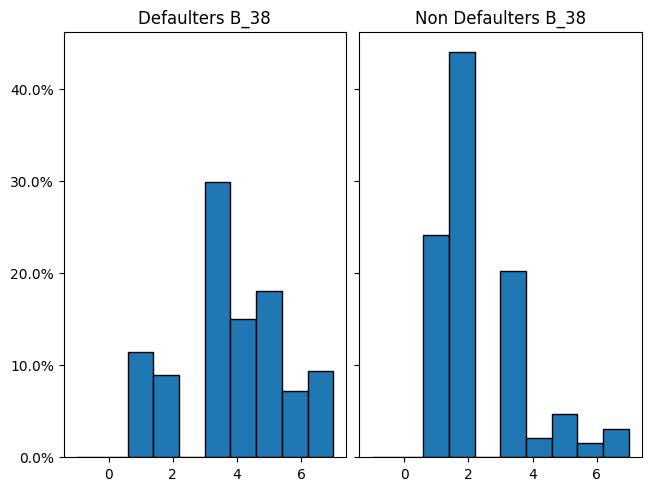

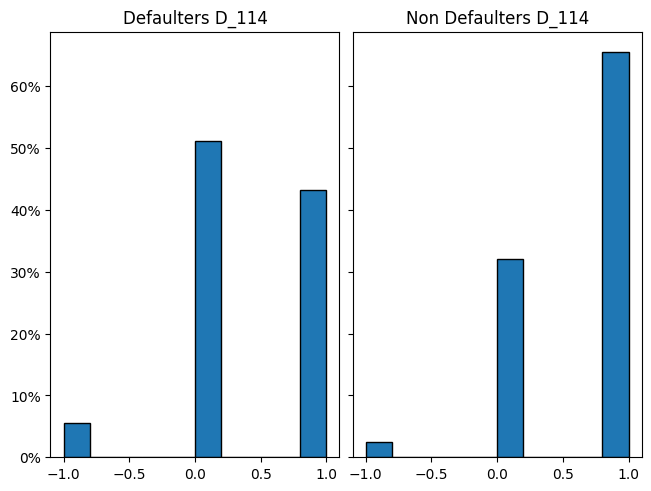

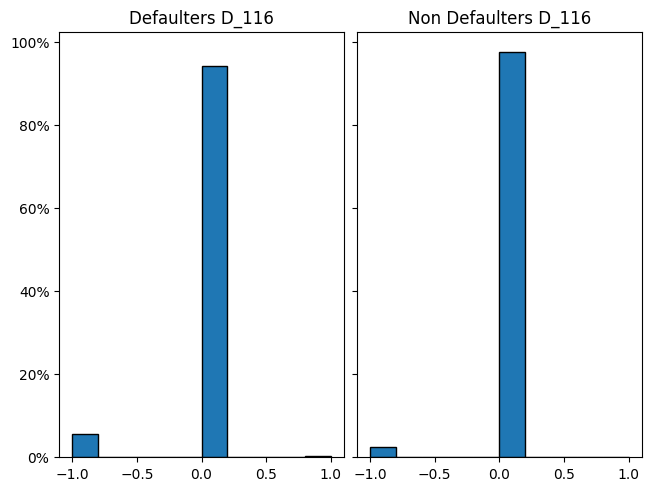

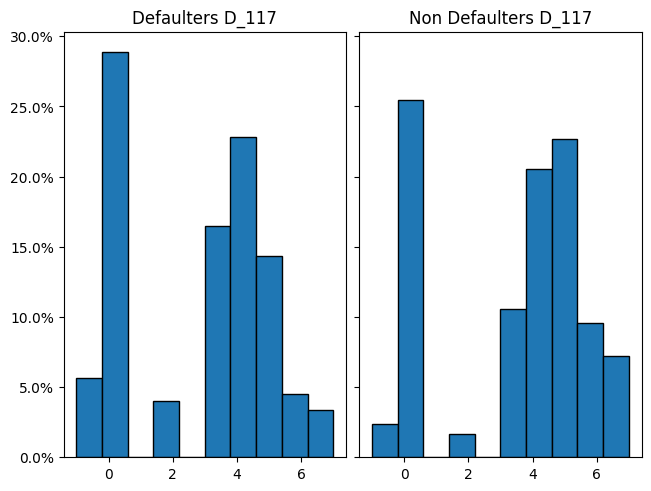

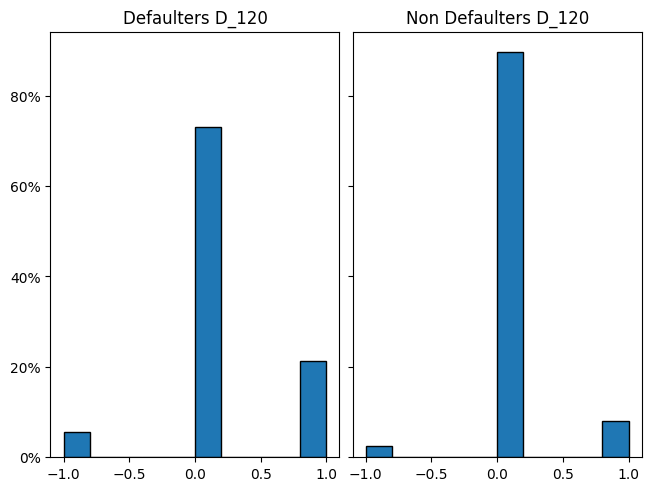

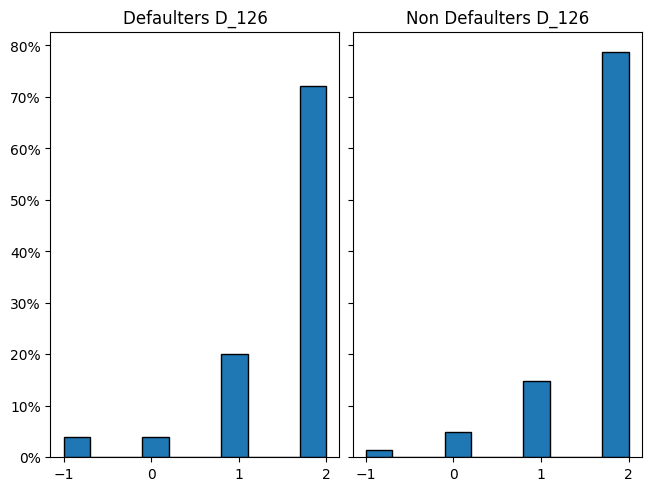

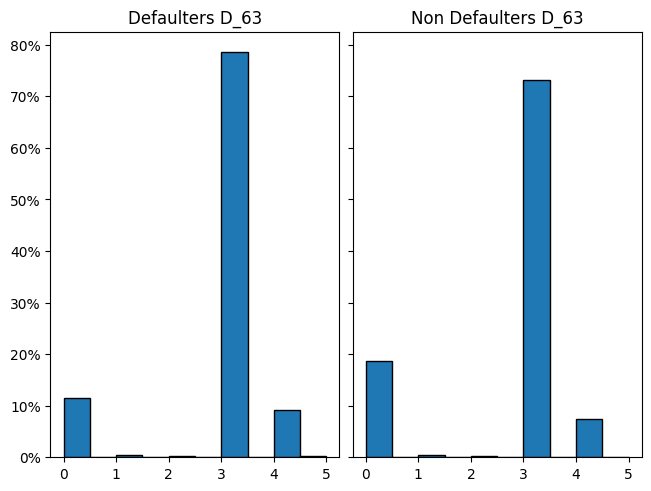

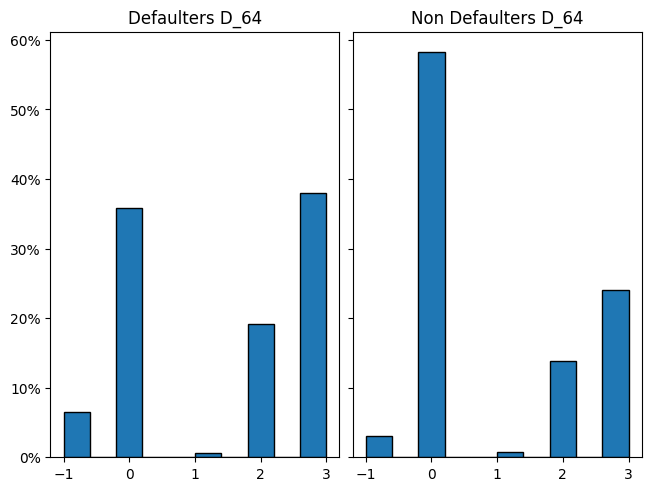

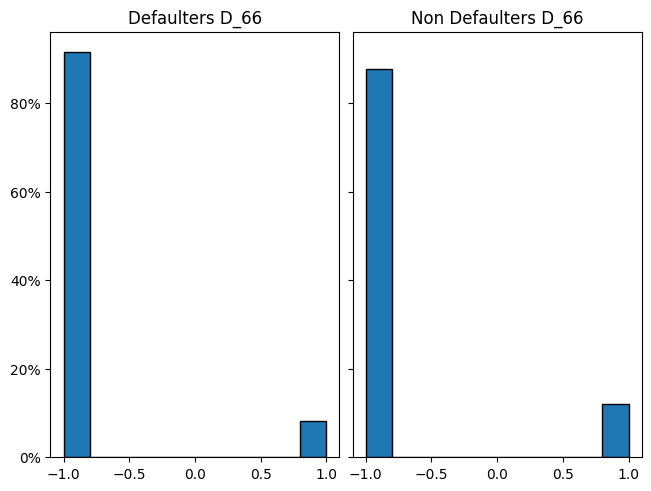

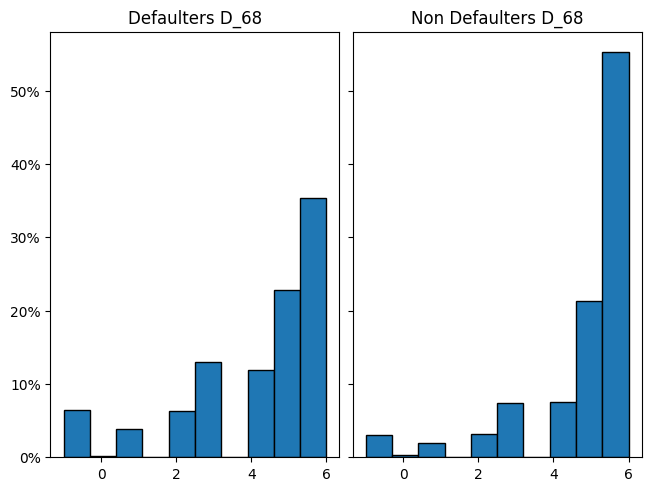

In [169]:
plot_histogram_grouped_by_target(large_dataset, category_cols)

Categorical columns B_30, B_38, D_64, D_117, D_120, D_68 are identified to contain useful information and must be retained. Out of these 4 columns (B_30, D_64, D_117, D_120) are flagged for too many zeros and should not be dropped while dropping columns with too many zeros.

Besides this since the training dataset contains almost 5.5 million records when in a column zeros are present for even 1% of data the record number is greater than threshold for pandas profiler and flags as too many zeros.

So, closely analyzing columns with only 10% or lesser values in data as zero i.e. ‘D_82', 'D_106', 'D_122', 'D_126', 'D_135', 'D_137', 'D_138’, 'R_26'.

In [215]:
cols_with_less_zeros = ['D_82', 'D_106', 'D_122', 'D_126', 'D_135', 'D_137', 'D_138', 'R_26']

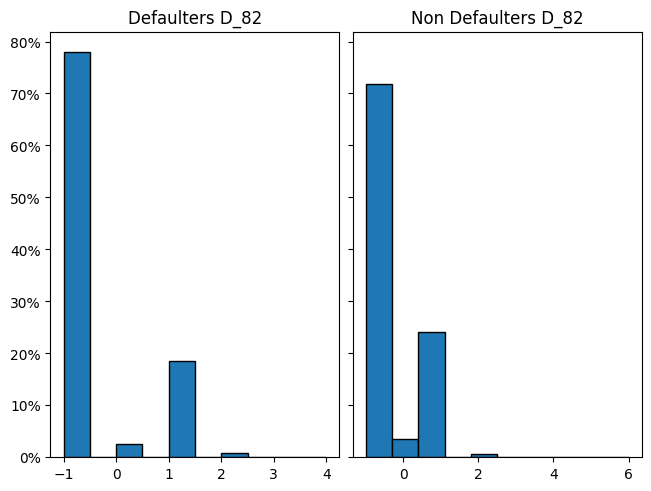

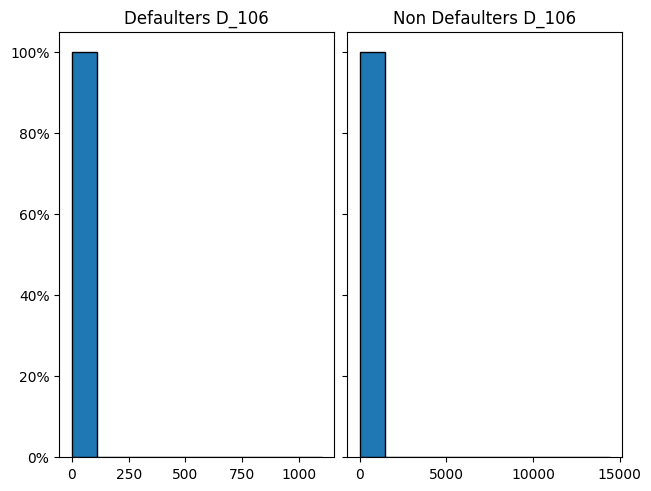

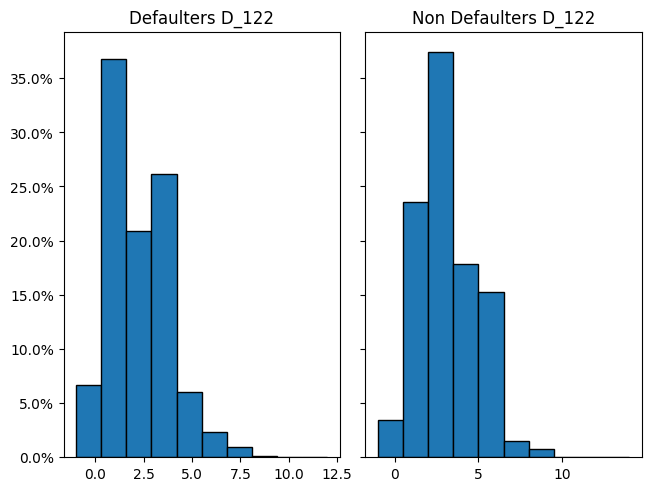

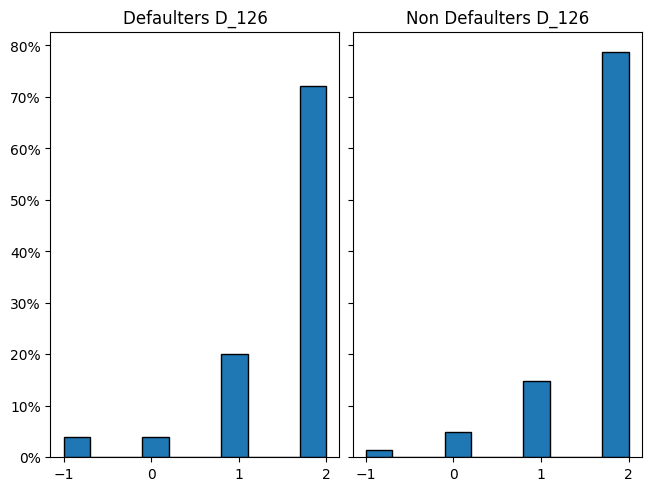

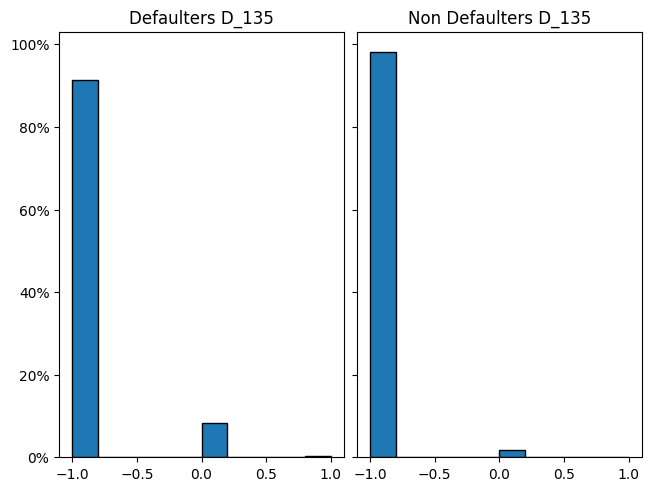

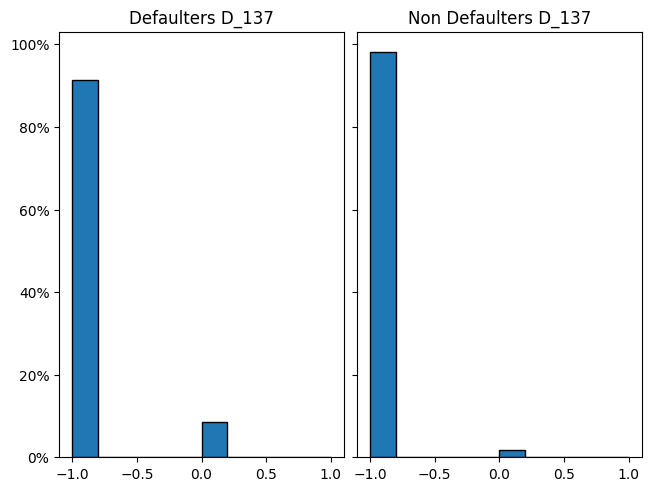

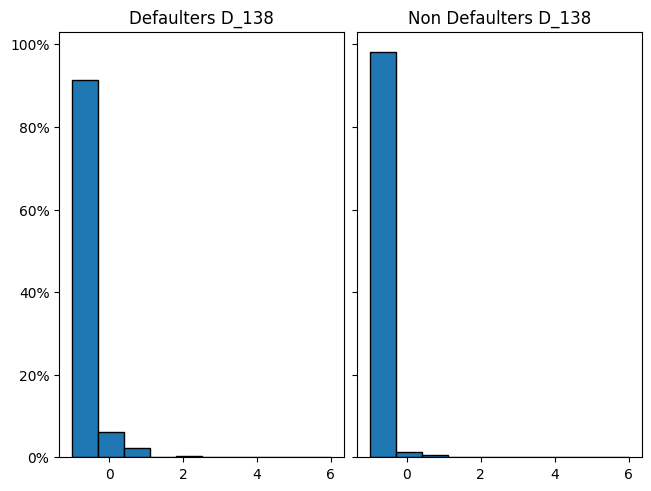

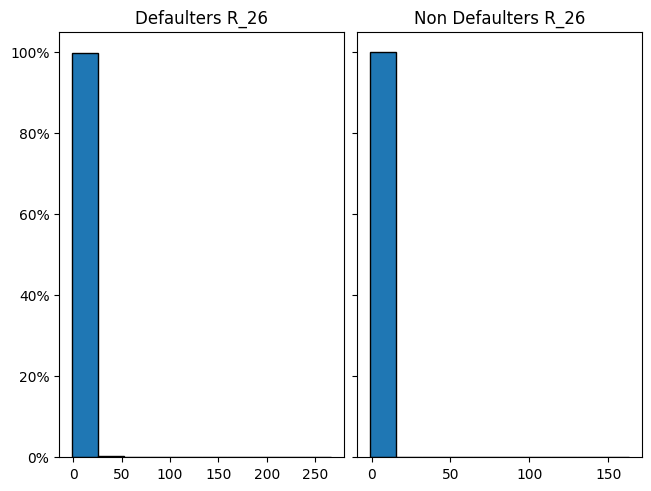

In [216]:
plot_histogram_grouped_by_target(large_dataset, cols_with_less_zeros)

D_82 and D_122 seem to contain some useful variance in data that can benefit the model. Hence, to be retained.

### Summary Many Zeros
All columns with many zeros except these B_30, B_38, D_64, D_117, D_120, D_82, D_122 and target can be safely dropped without much information loss.

### ----Highly Skewed----
In case of highly skewed, the skewness is attempted to be reduced by removing the lower and higher outliers to see if meaningful information exists in the columns.

In [162]:
skewed_cols = ['B_5','D_49','B_6','D_50','B_10','S_5','B_12','B_13','B_14','D_61','B_15','D_65','S_12','B_21','D_69','D_71','B_24','R_7','B_26','S_16','R_13','R_14','D_87','R_17','R_18','R_20','R_23','S_22','S_23','S_24','S_26','D_106','R_26','B_40','D_123','R_28']

In [217]:
def remove_outliers(col):
    df_filtered = large_dataset.copy(deep=True)
    q_low = large_dataset[col].quantile(0.01)
    q_hi  = large_dataset[col].quantile(0.99)
    df_filtered = large_dataset[(large_dataset[col] < q_hi) & (large_dataset[col] > q_low)]
    return df_filtered

/var/folders/f6/h9tjzl5x5jn3mp_0f599bpjr0000gn/T/ipykernel_9616/1322368089.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, constrained_layout = True, sharey=True)


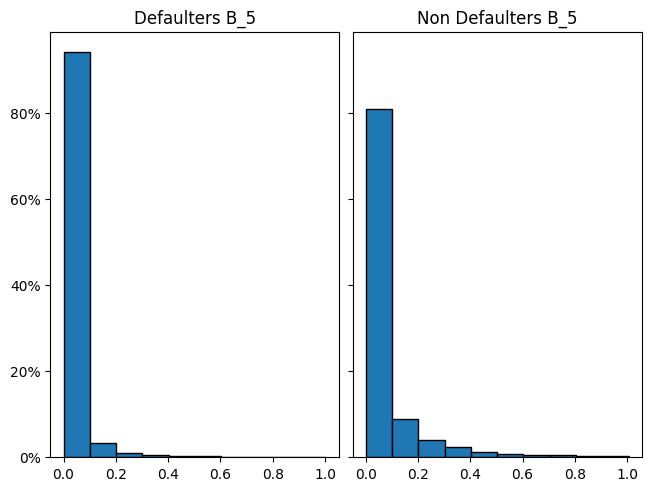

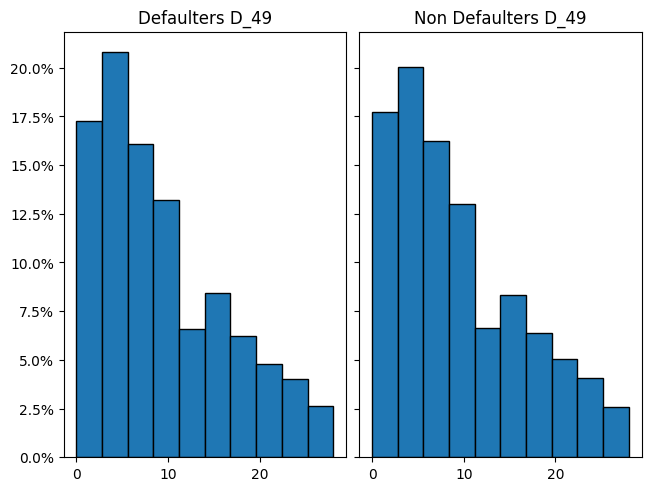

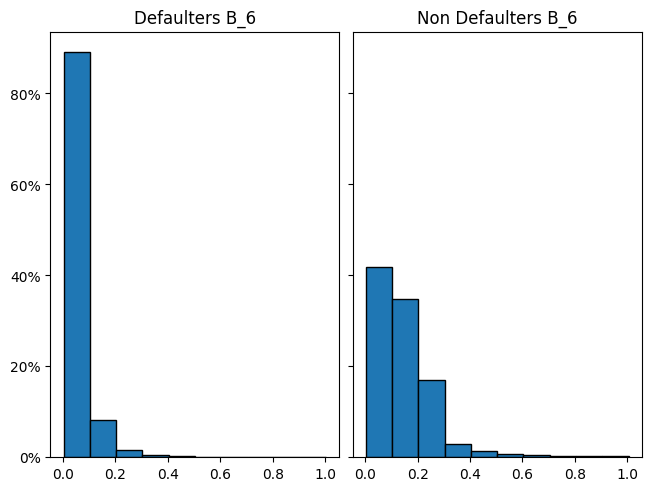

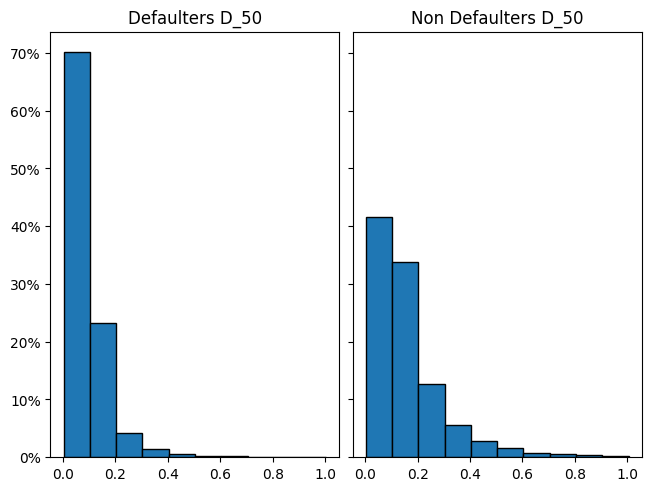

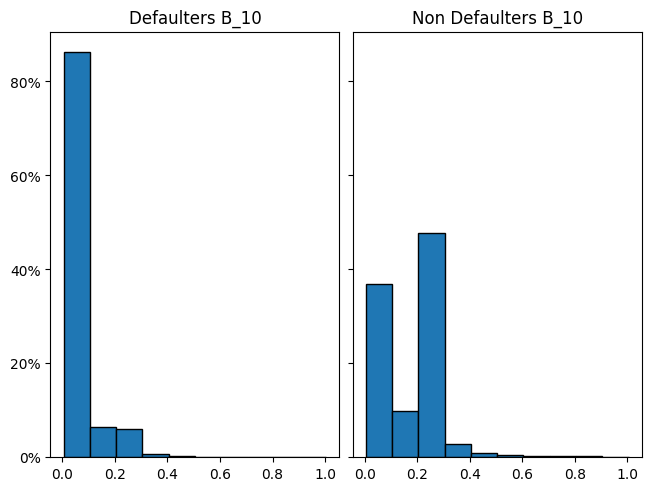

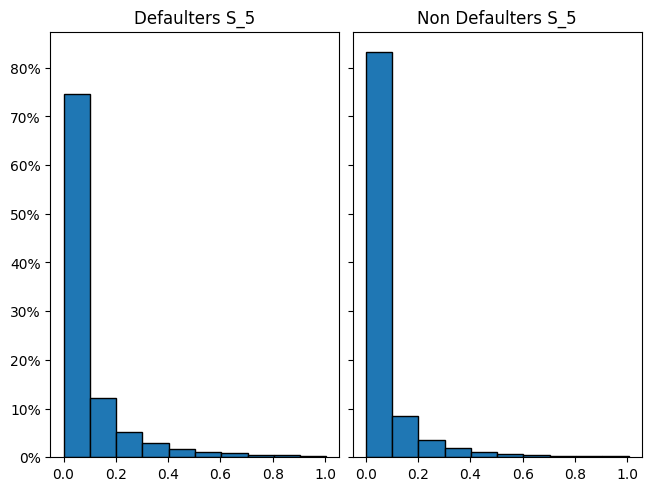

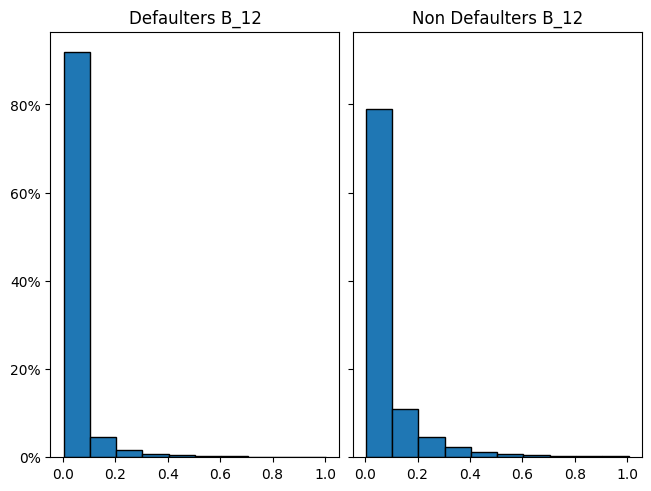

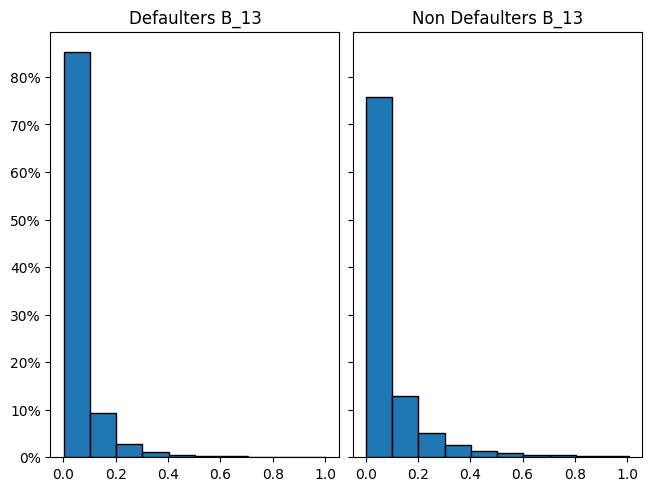

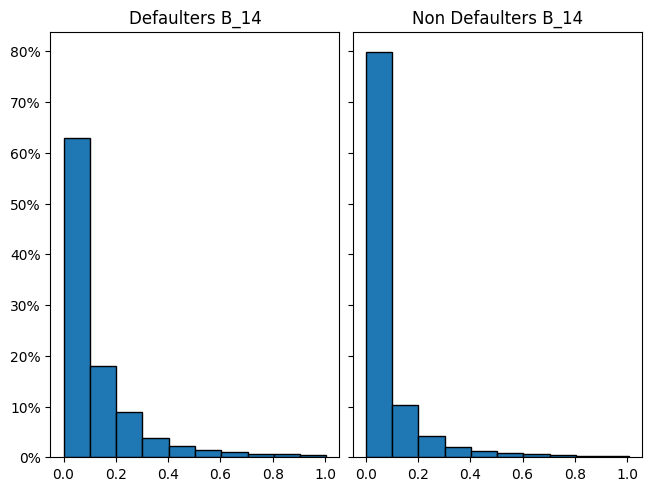

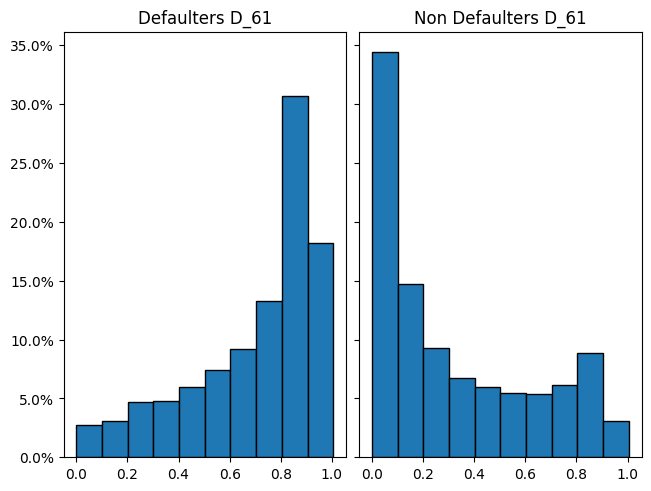

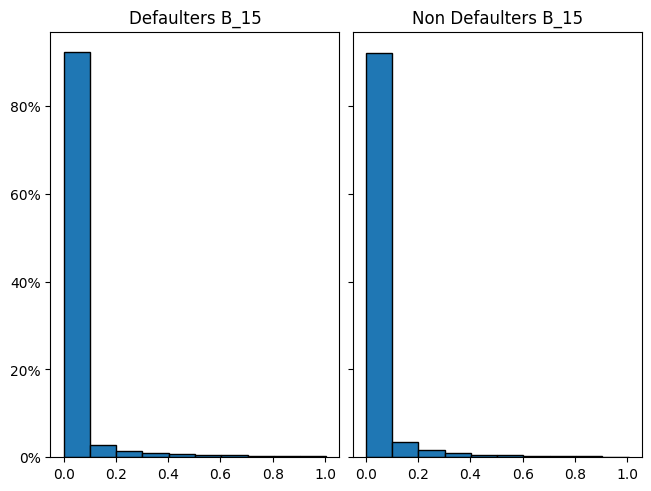

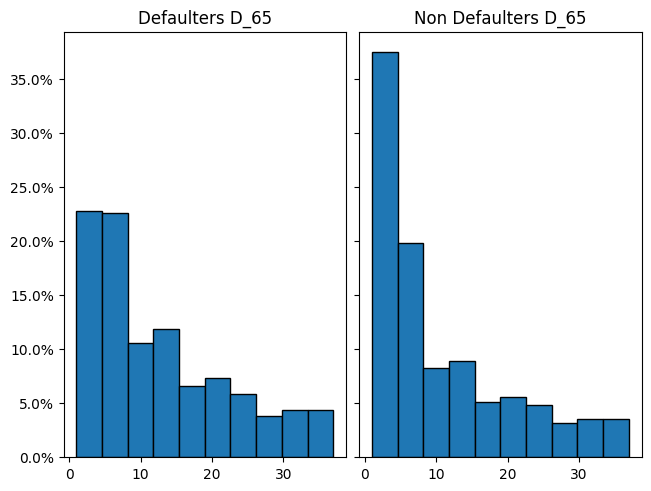

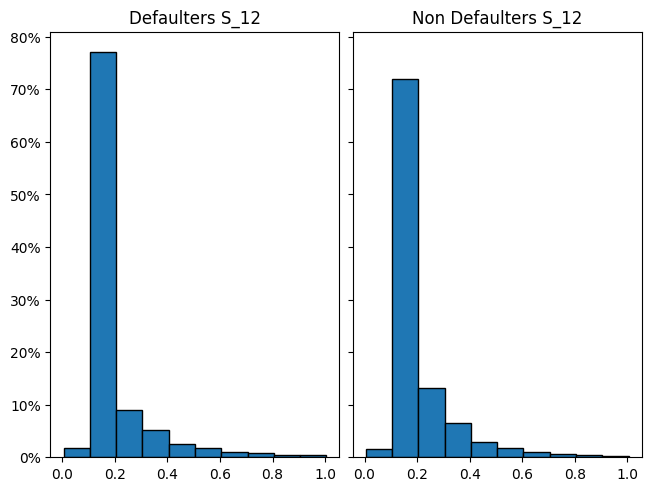

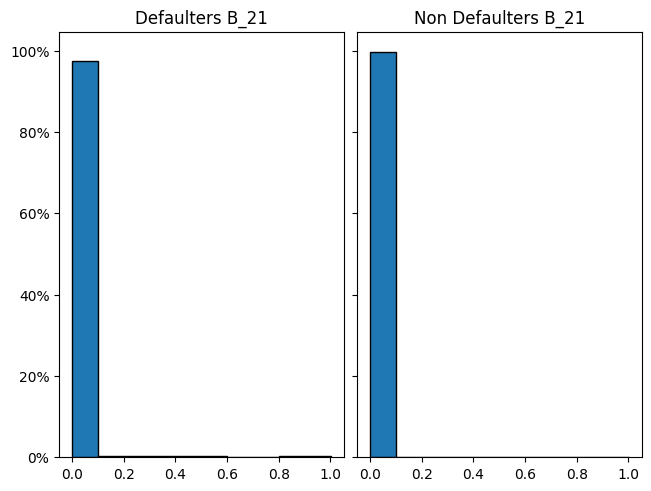

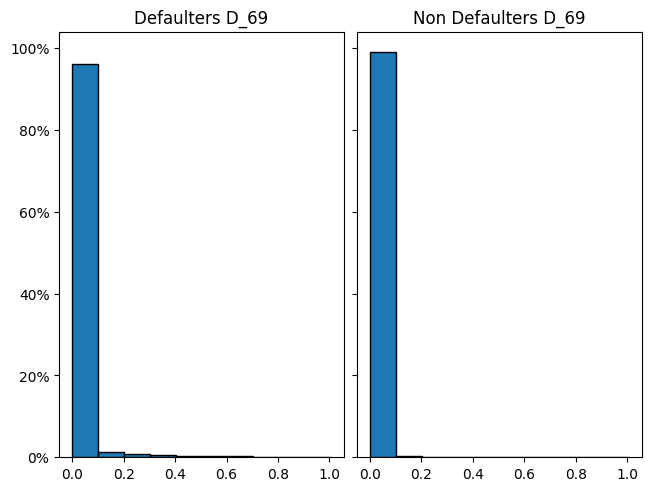

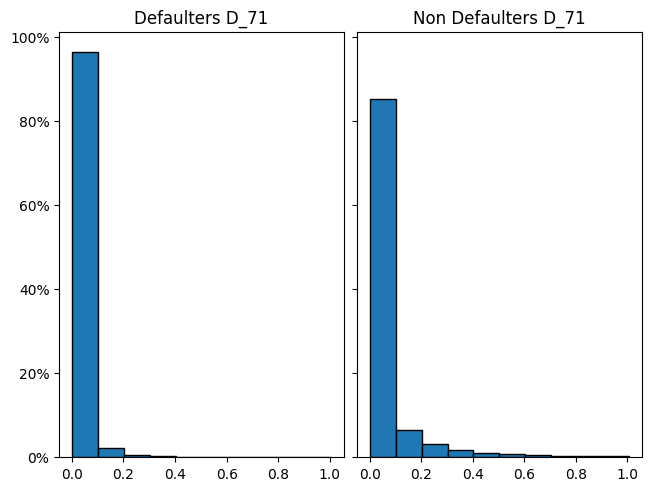

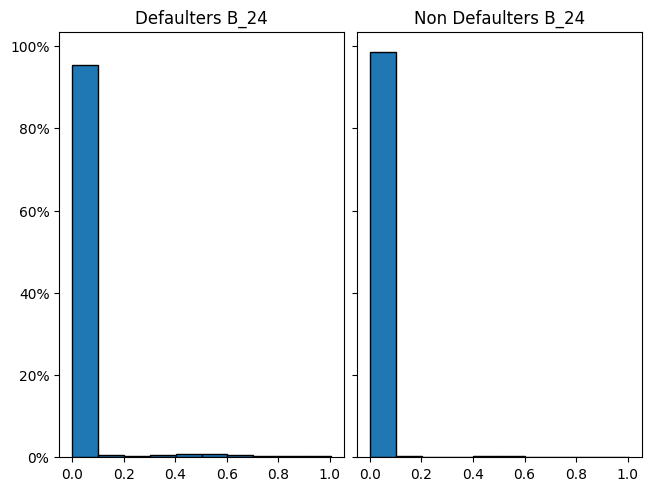

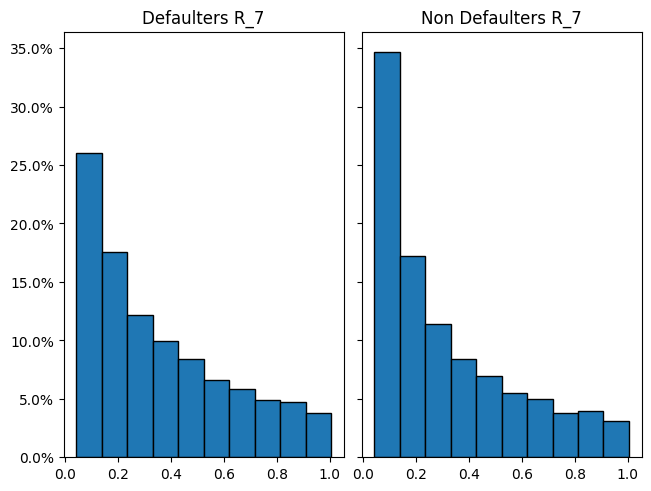

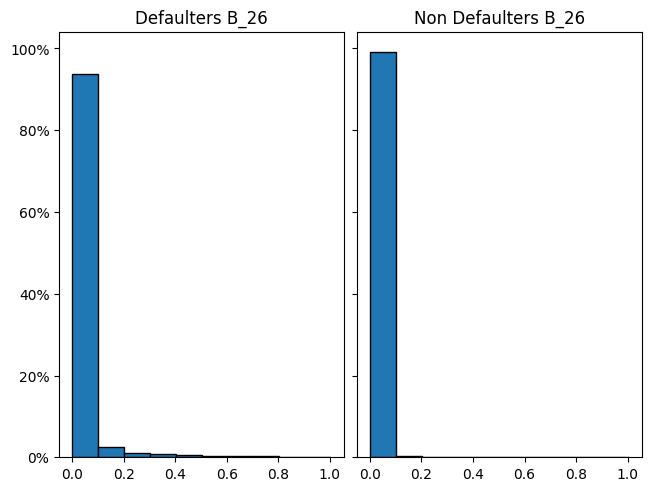

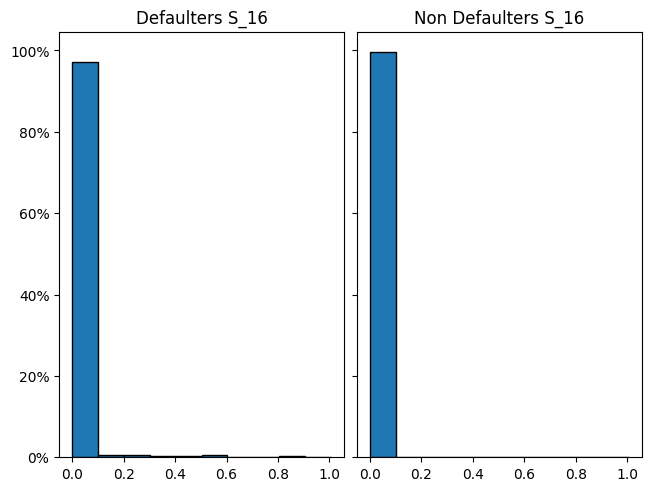

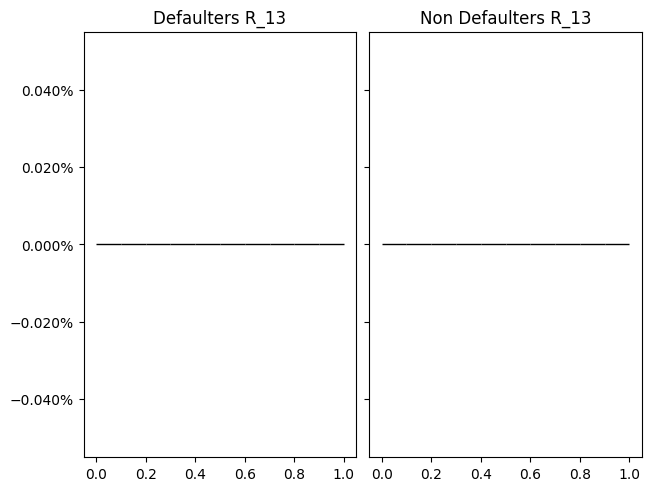

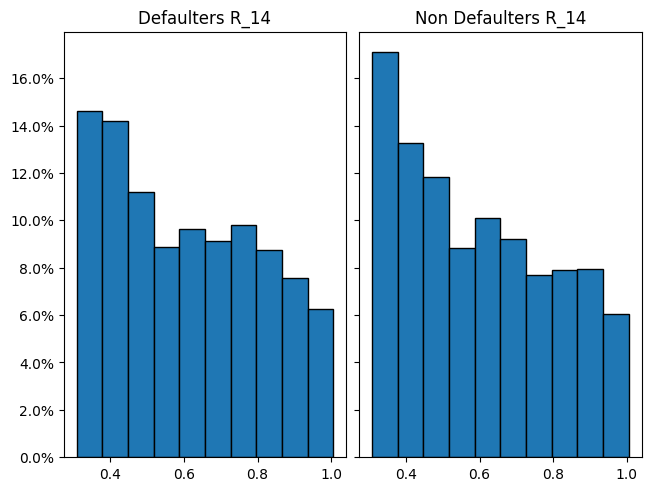

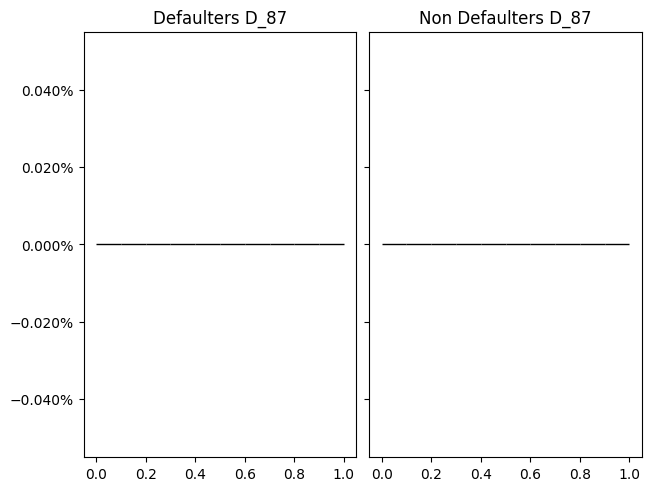

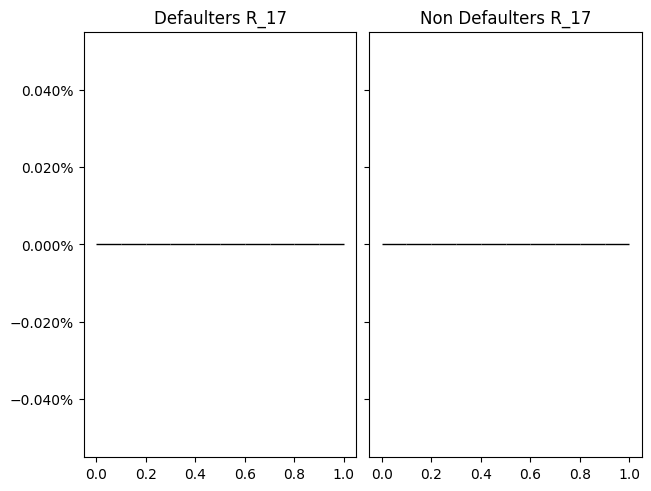

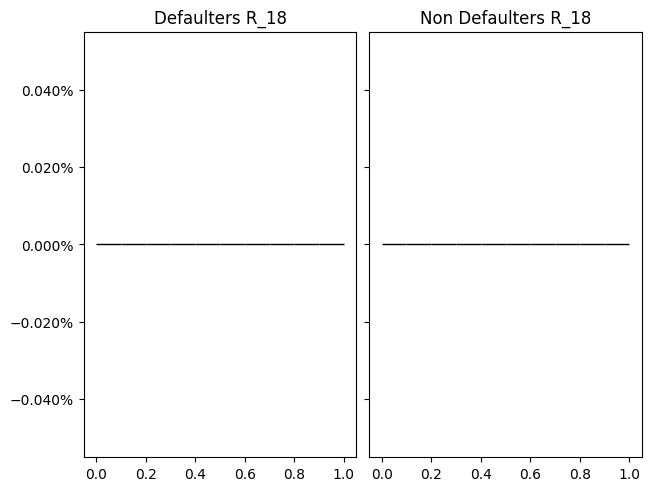

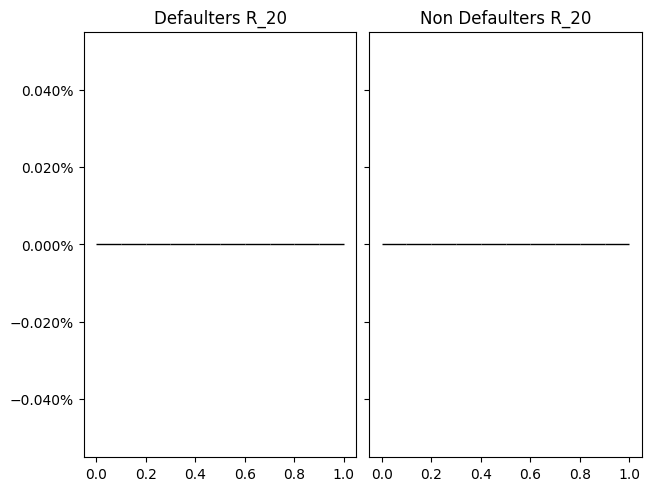

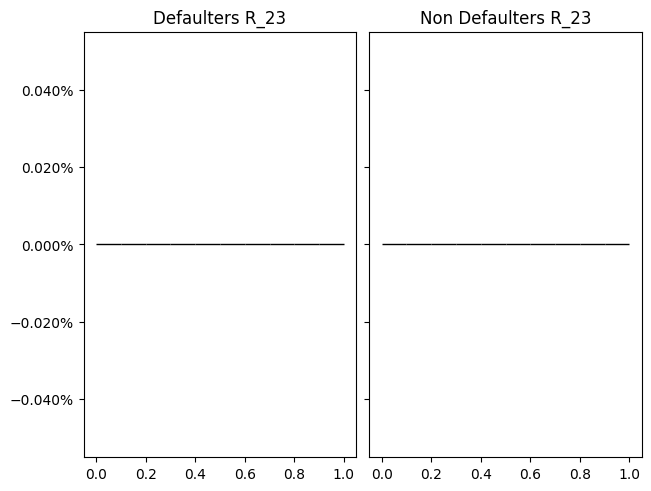

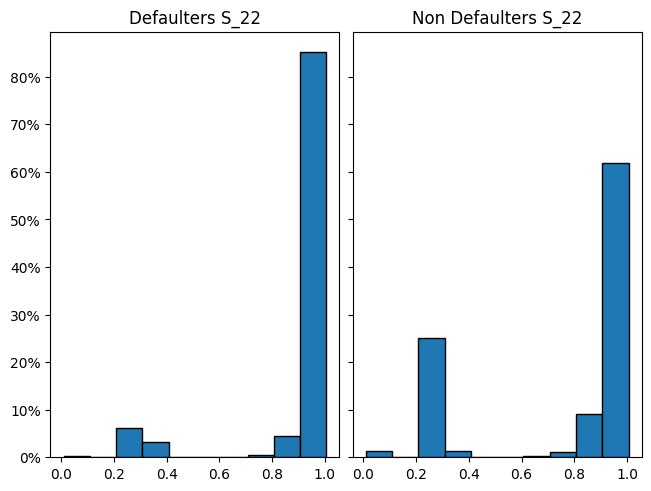

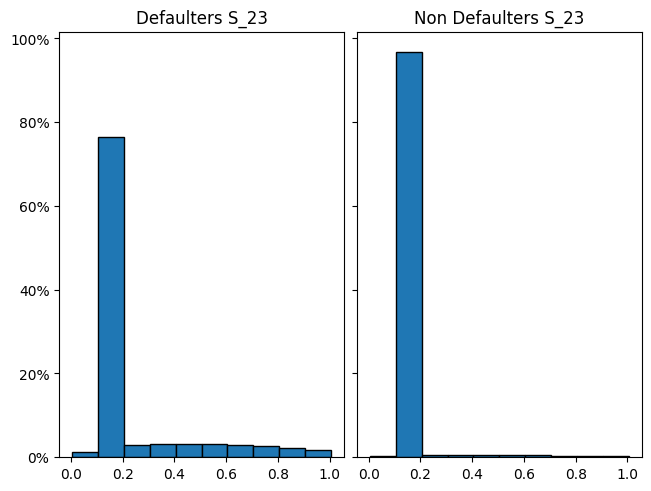

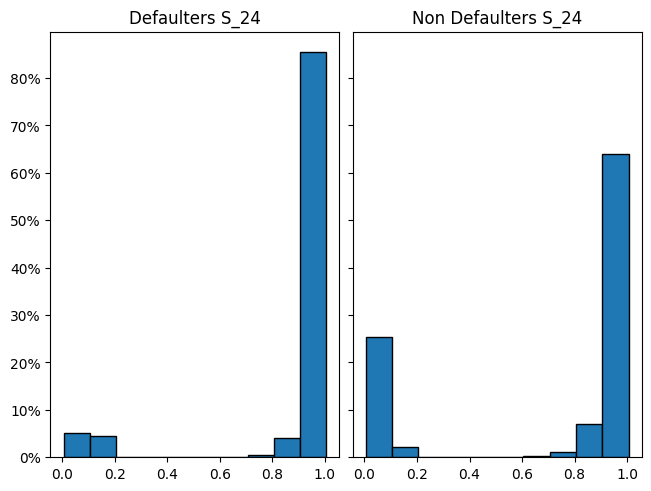

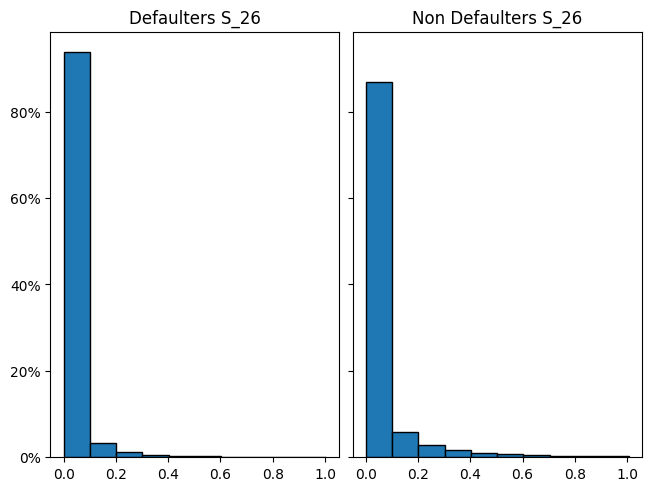

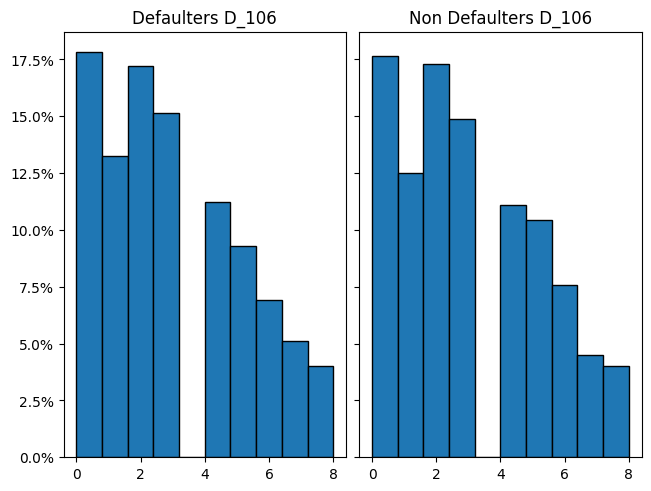

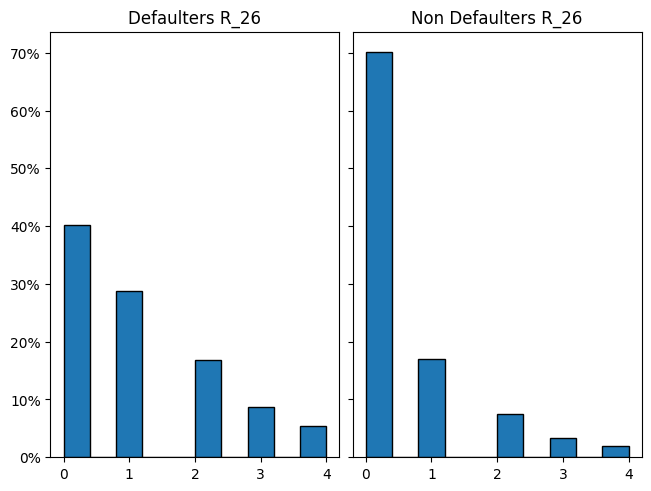

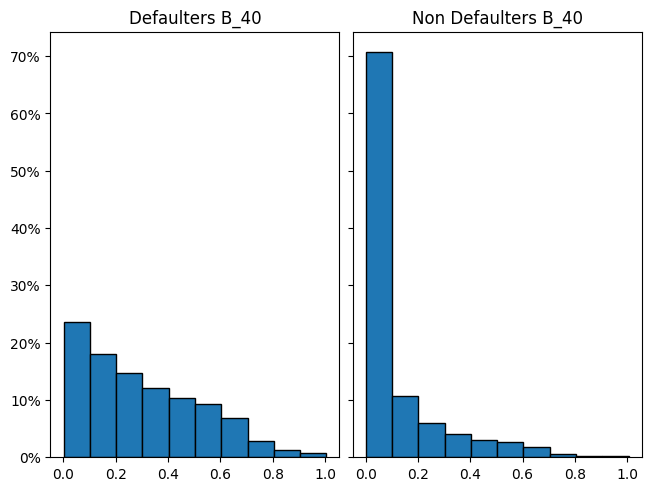

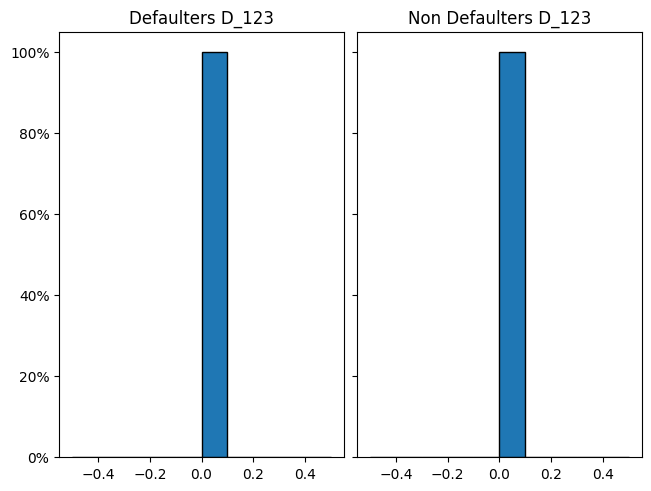

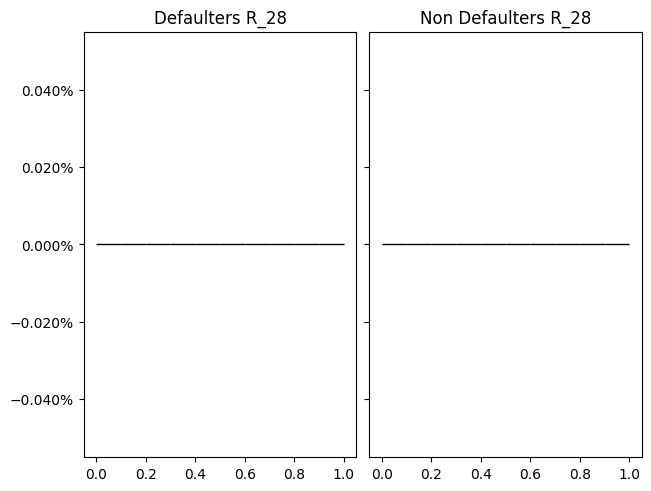

In [218]:
for col in skewed_cols:
    large_dataset_without_outliers = remove_outliers(col)
    plot_histogram_grouped_by_target(large_dataset_without_outliers, [col])

### Summary Highly Skewed
Skewed Columns: ‘D_61', 'S_22', 'S_23', 'S_24', 'B_40’ seems to display most significance when outliers are dropped. Thereby these must be retained when rest of the highly skewed columns are dropped.

### ----Missing values----
Columns with highly missing values might still have some interesting patterns and the ones with relatively less missing data and interesting patterns can be retained.

In [206]:
# Missing values
missing_cols = ['S_3', 'D_42', 'D_43', 'D_46', 'D_48', 'D_50', 'P_3', 'D_53', 'S_7', 'D_55', 'D_56', 'S_9', 'D_61', 'D_62', 'B_17', 'D_69', 'D_73', 'D_76', 'D_77', 'B_29', 'D_88', 'D_104', 'D_105', 'R_27', 'D_110', 'B_39', 'S_27', 'D_115', 'D_118', 'D_119', 'D_121', 'D_128', 'B_42', 'D_130', 'D_131', 'D_132', 'D_134', 'D_141', 'D_142']

/var/folders/f6/h9tjzl5x5jn3mp_0f599bpjr0000gn/T/ipykernel_9616/1322368089.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, constrained_layout = True, sharey=True)


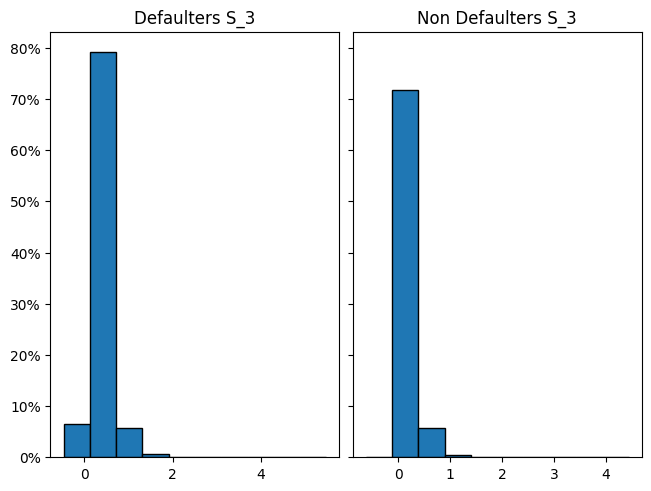

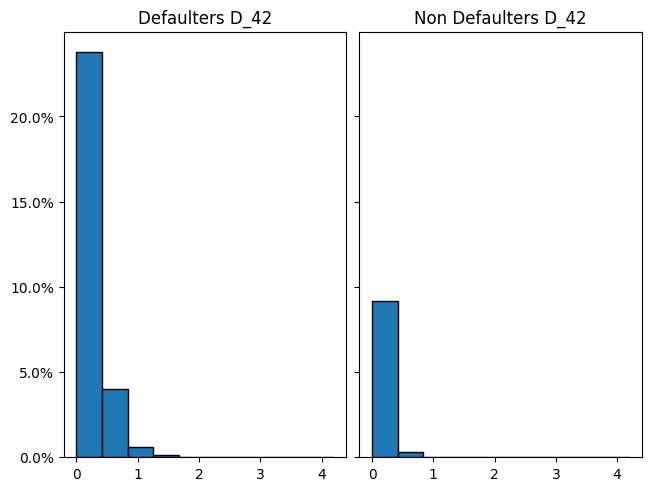

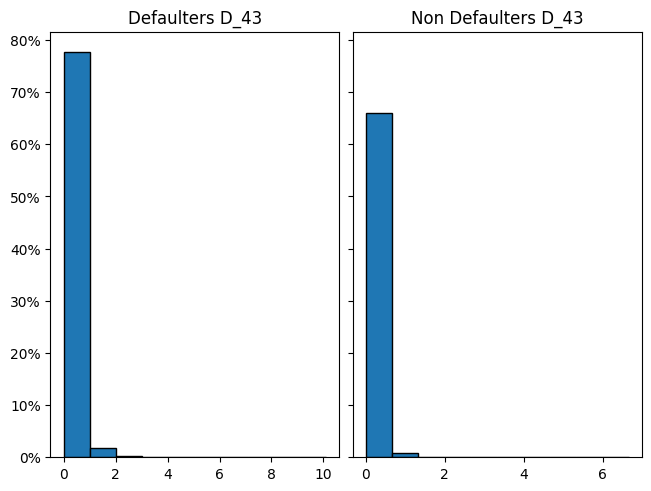

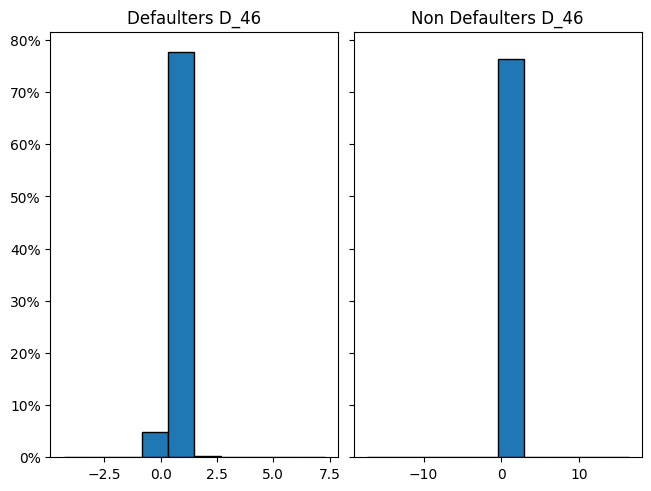

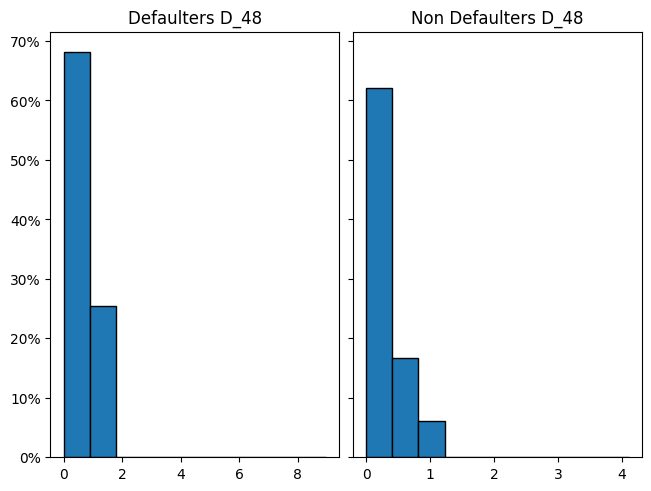

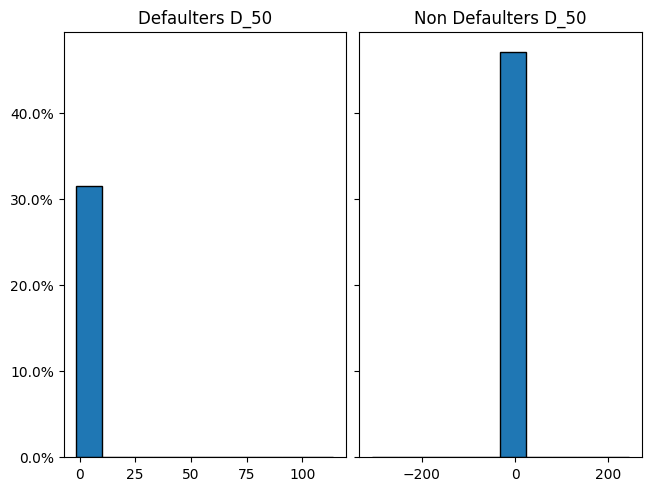

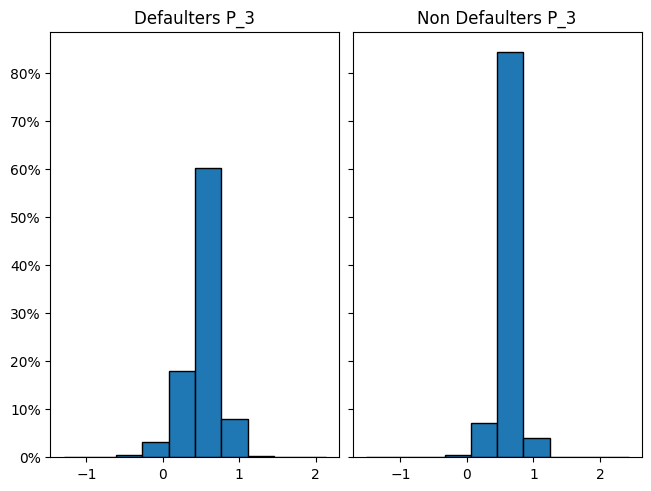

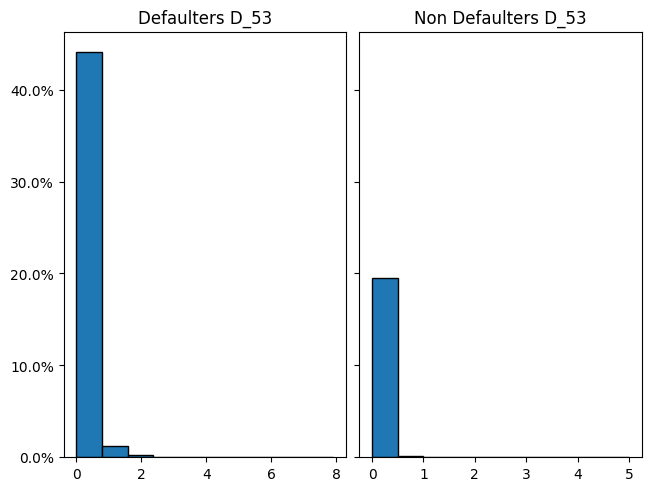

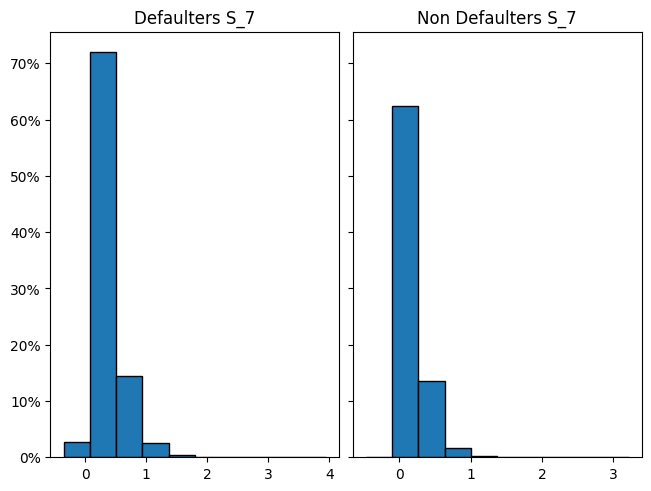

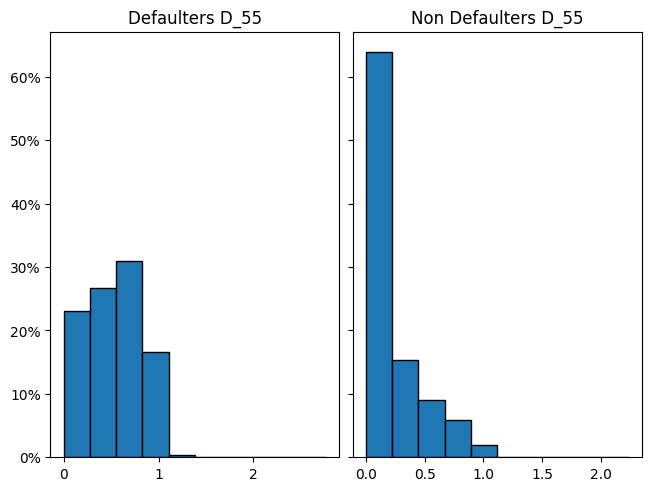

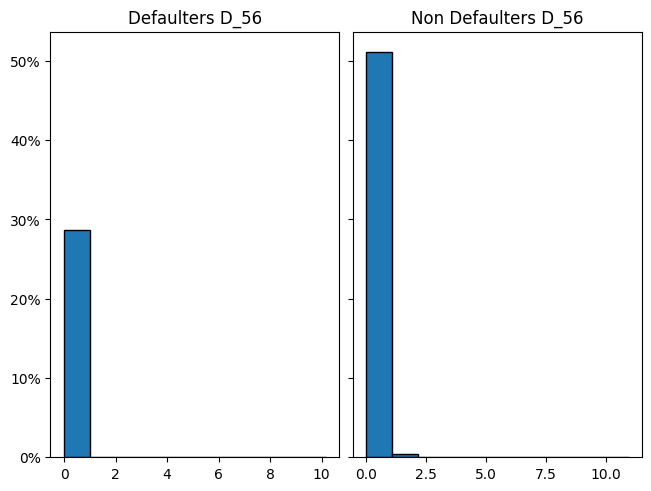

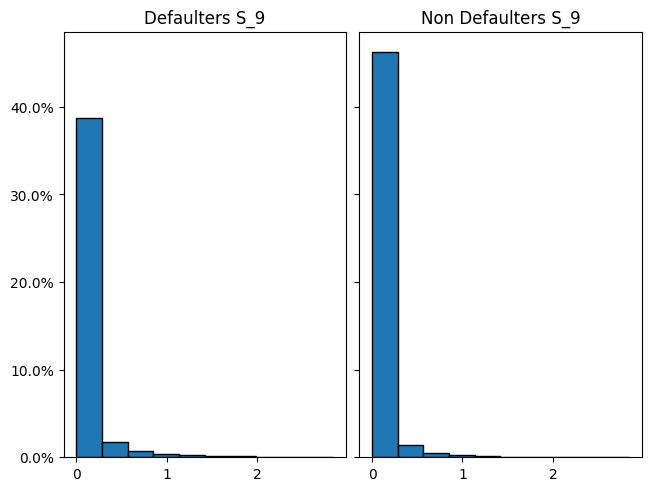

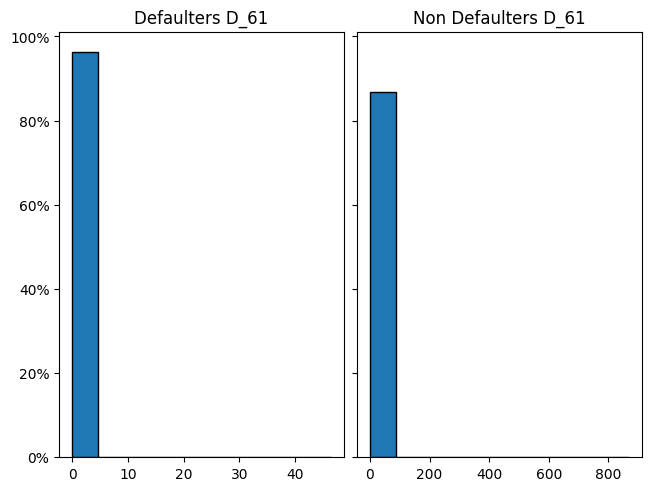

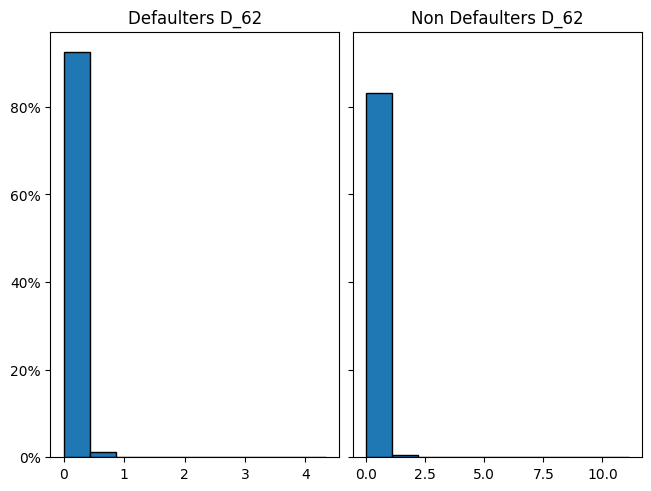

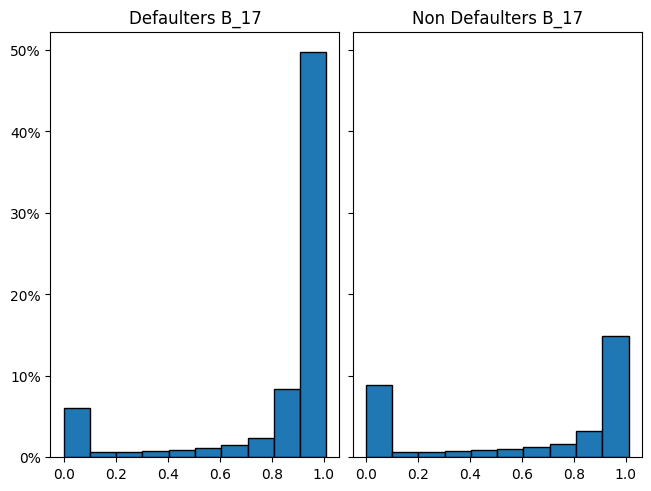

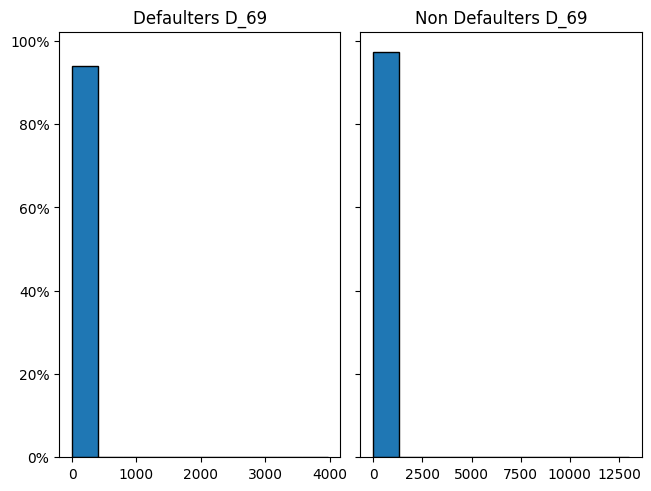

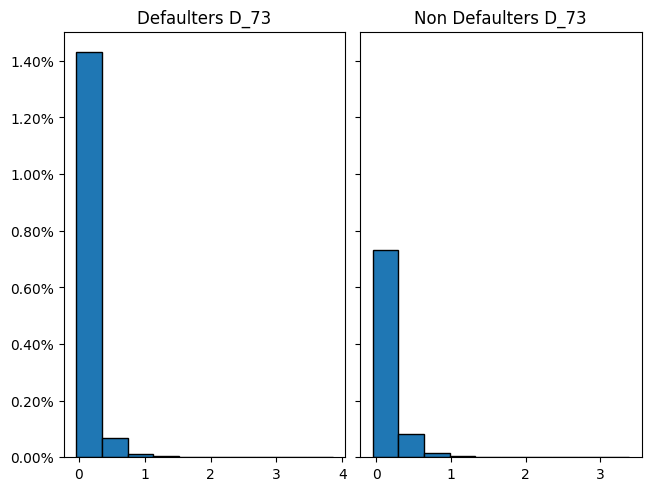

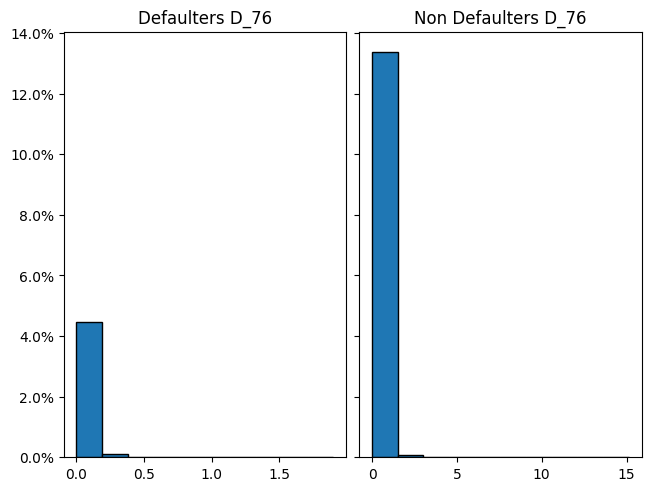

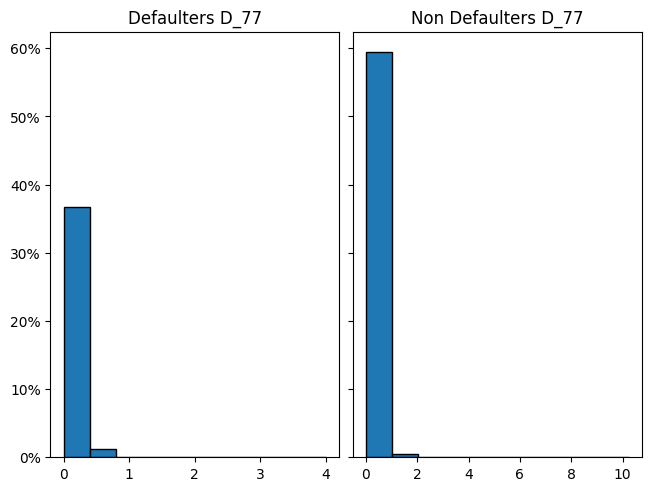

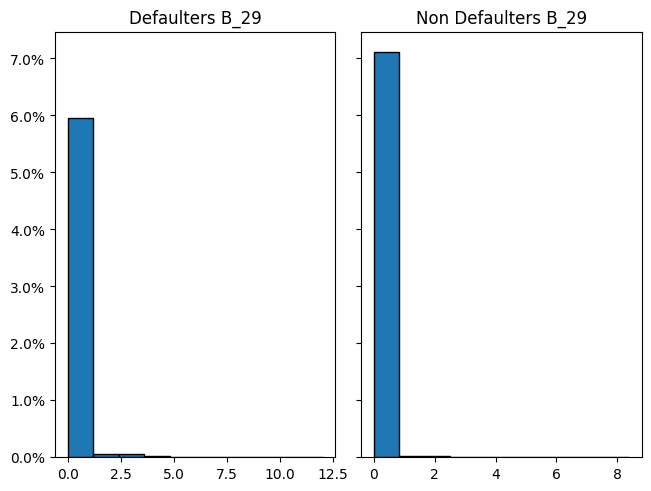

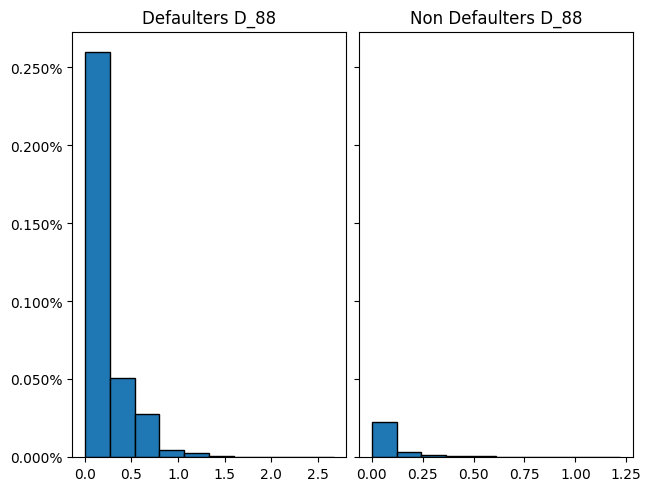

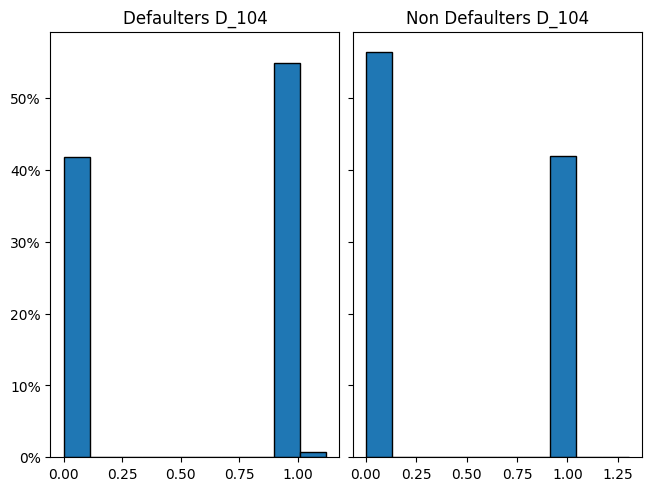

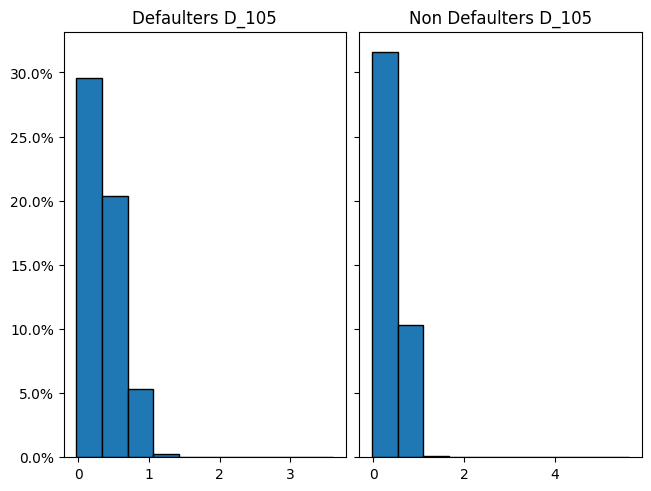

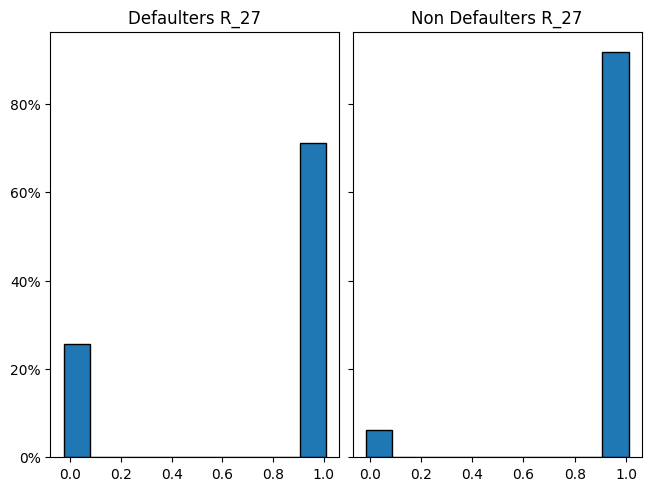

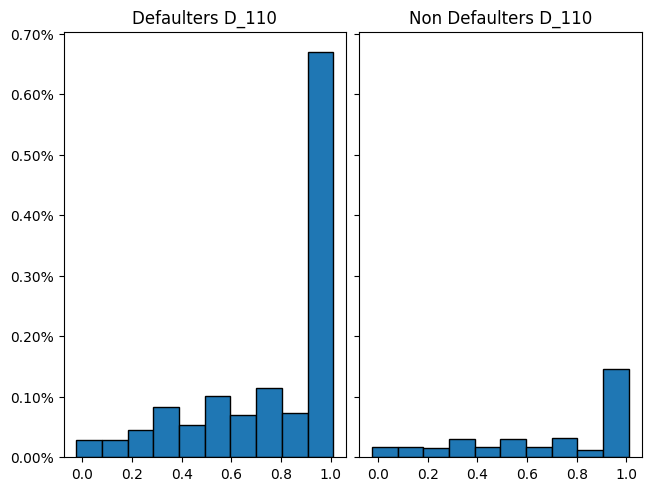

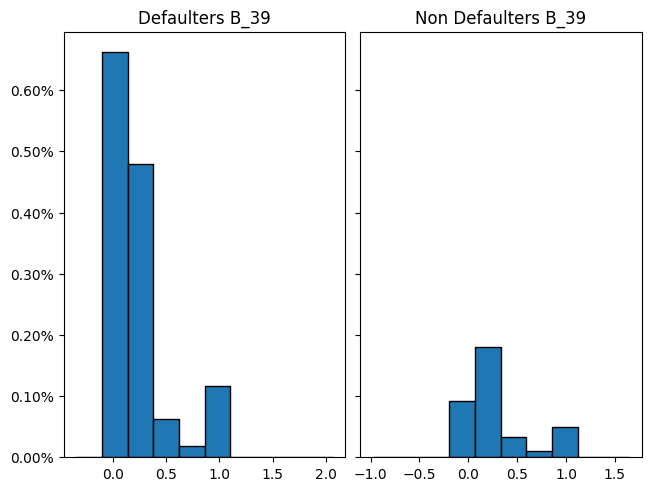

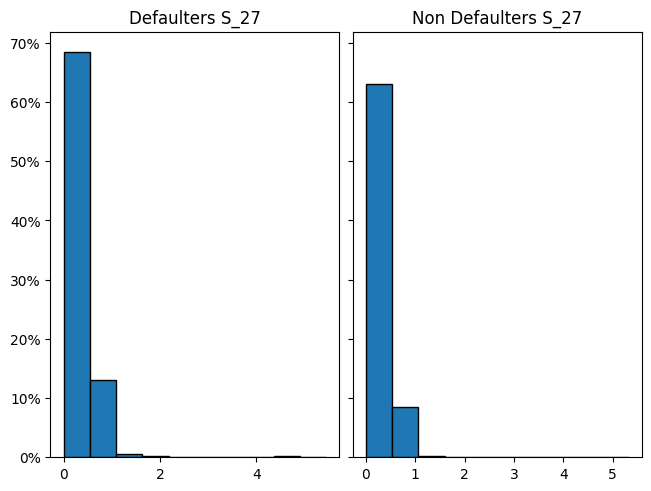

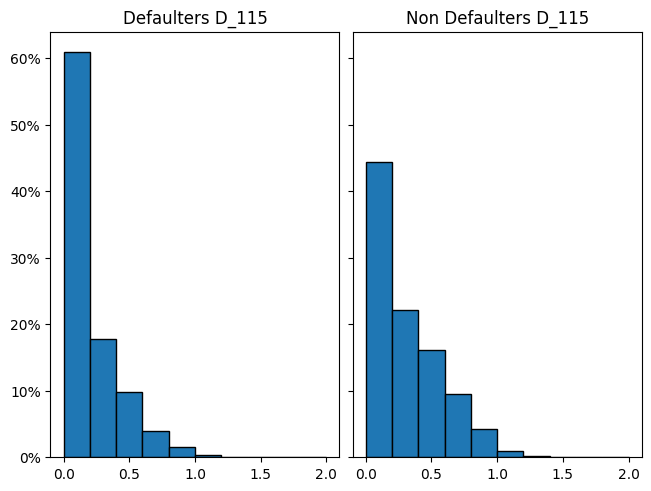

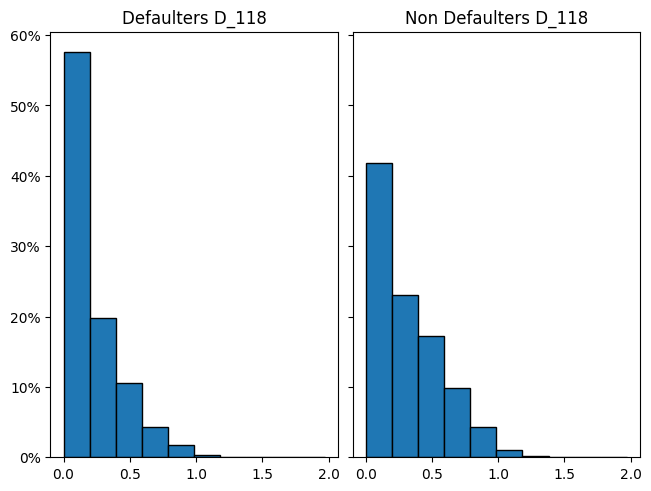

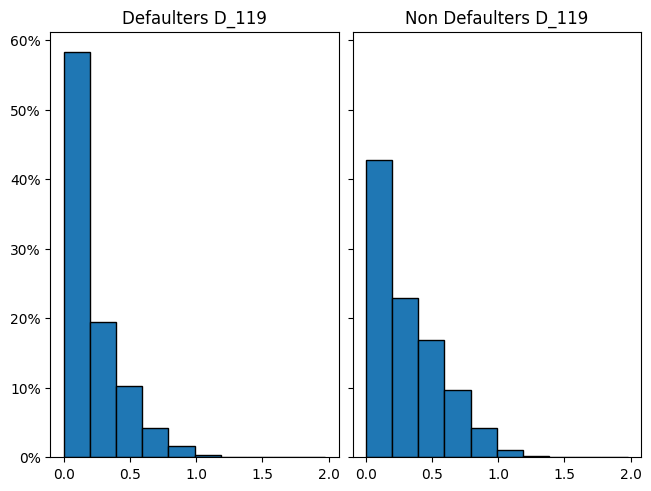

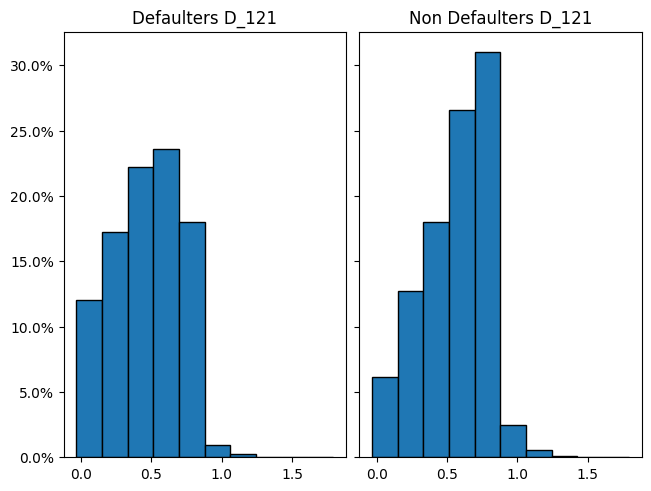

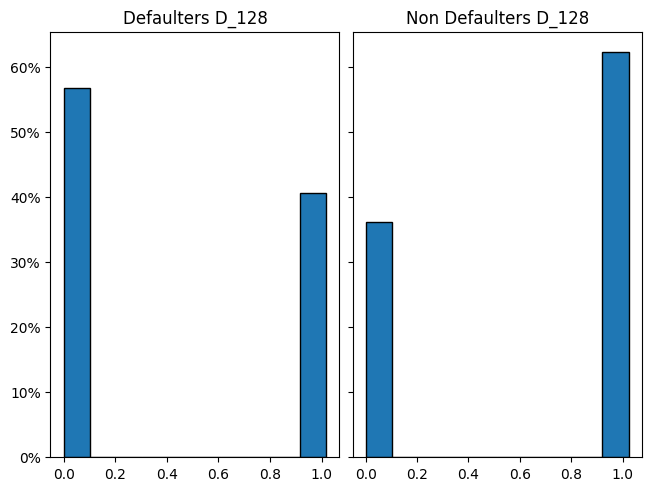

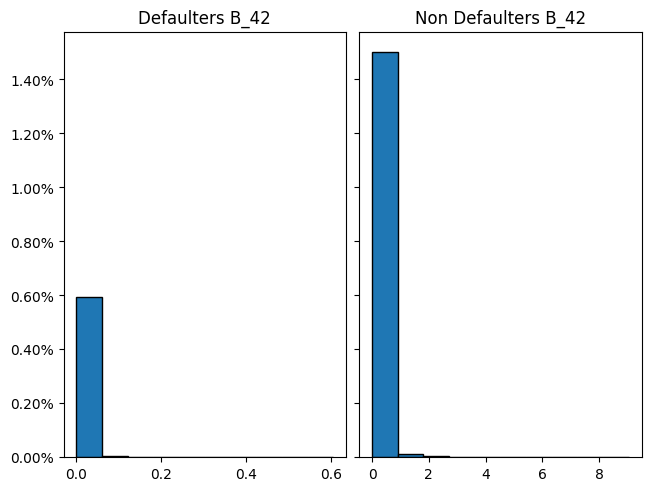

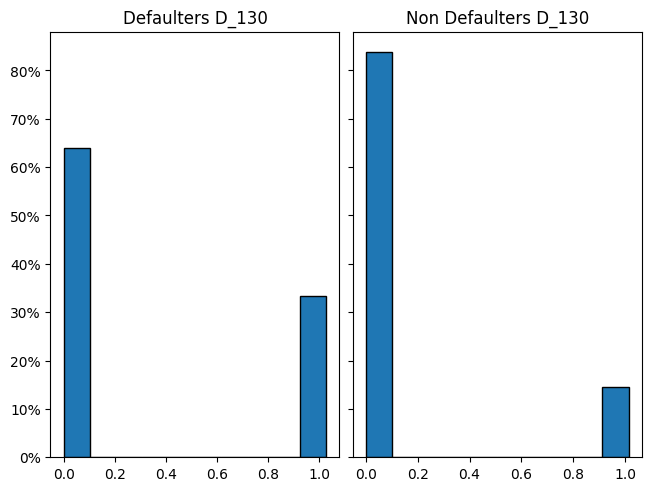

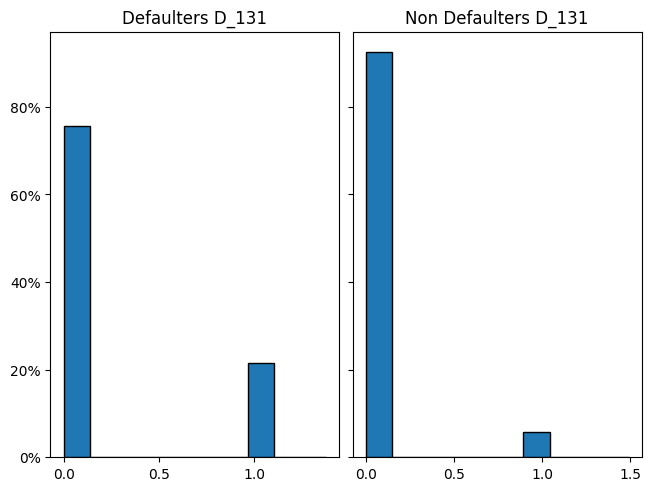

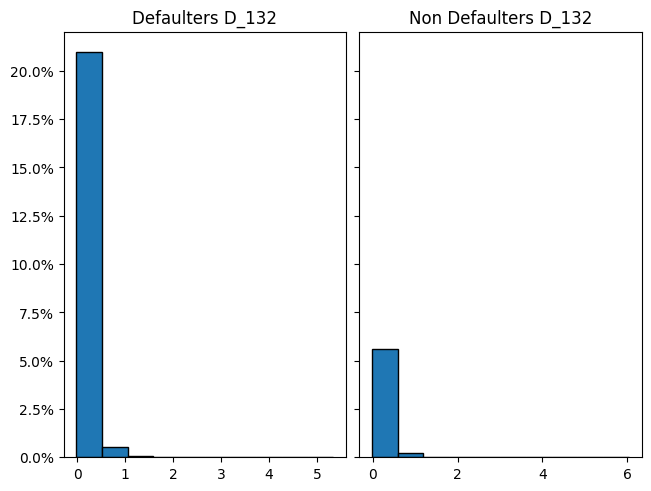

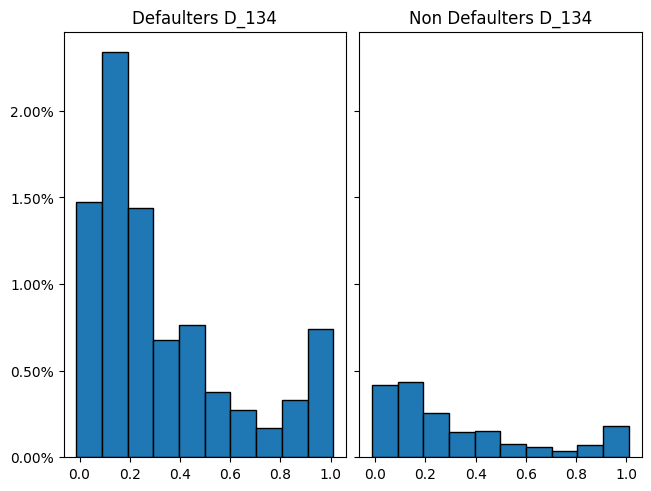

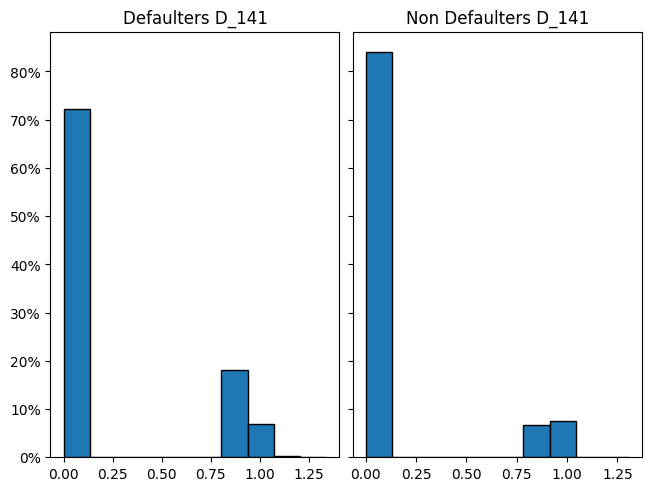

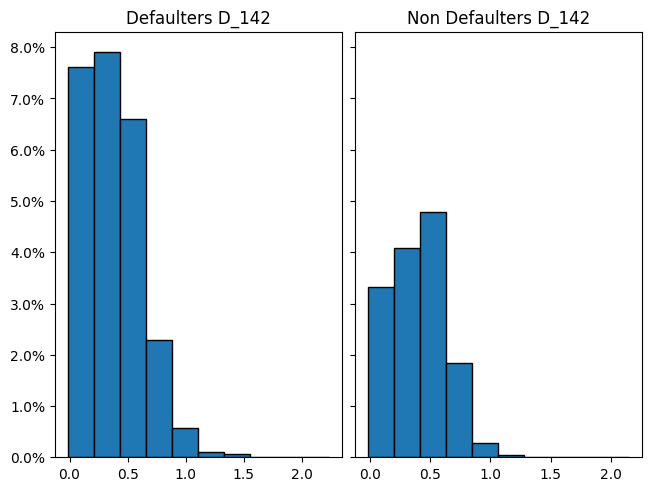

In [209]:
plot_histogram_grouped_by_target(large_dataset, missing_cols);

### Summary Highly Missing data
Columns ‘P_3’, 'D_55', 'D_104', 'R_27', 'D_115', 'D_118', 'D_119', 'D_121', 'D_128’ have less than 10% missing data and also contain some interesting variance in data. Hence, must be retained.

### ----High Cardinality----
Columns 'customer_ID' and 'S_2' are flagged for high cardinality as expected.

customer_ID has 458913 distinct values in training data i.e. there should be approximately 12 rows per customer. 
S_2 has 396 distinct values. On closer examination S_2 is a date on which the customer received the statement.

Since customers can display specific spending behavior based on season (e.g. overspending during festive season) a combination of customer_id and statement month can be a useful feature for the model.

In [12]:
customer_statement_counts = large_dataset.customer_ID.value_counts().value_counts()
print(customer_statement_counts)

13    386034
12     10623
10      6721
9       6411
8       6110
2       6098
11      5961
3       5778
6       5515
7       5198
1       5120
4       4673
5       4671
Name: customer_ID, dtype: int64


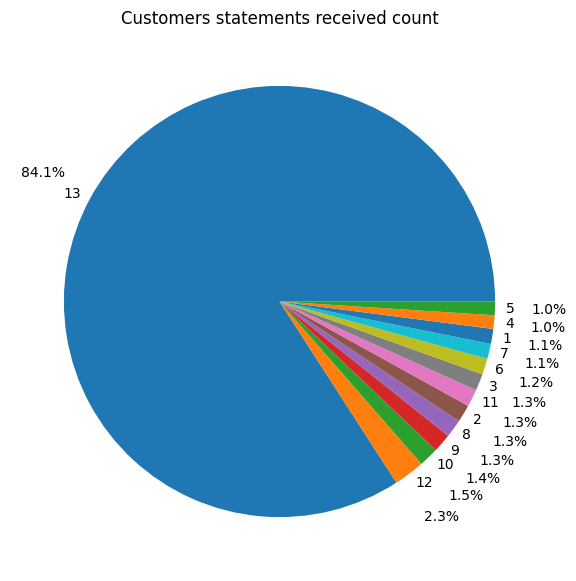

In [49]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(customer_statement_counts, labels=customer_statement_counts.index, autopct='%1.1f%%', pctdistance=1.25,labeldistance=1.05);
ax.set_title("Customers statements received count");

The above analysis shows that there most of the customers have received 13 statements while some have received 12 or lesser number of statements.

### Summary High Cardinality column

1. Most customers have received close to 13 statements. This information should be used while sampling the data for the model.
2. A new feature comprising of Customer_ID and Month of Statement from S_2 needs to be engineered before dropping the 2 columns to capture seasonality information.

### ----Columns not alerted by Pandas profiler----

Studying columns not alerted for any issues by Pandas profiler. This can help us get rid of columns that don't contribute any meaningful information to distinguish between defualters and non- defaulters.

In [67]:
# Creating folders for storing analysis plot
!mkdir -p ./plots/column-mean
!mkdir -p ./plots/column-min
!mkdir -p ./plots/column-max

In [3]:
# Drop all columns flagged by Pandas profiler (except customer_ID, S_2 and target)to retain only the non-flagged ones
temp_drop_columns = ['D_42','S_3','D_43','D_46','D_48','D_50','P_3','D_53','S_7','D_55','D_56','S_9','D_61','D_62','B_17','D_69','D_73','D_76','D_77','B_29','D_88','D_104','D_105','R_27','D_110','B_39','S_27','D_115','D_118','D_119','D_121','D_128','B_42','D_130','D_131','D_132','D_134','D_141','D_142','B_5','D_49','B_6','D_50','B_10','S_5','B_12','B_13','B_14','D_61','B_15','D_65','S_12','B_21','D_69','D_71','B_24','R_7','B_26','S_16','R_13','R_14','D_87','R_17','R_18','R_20','R_23','S_22','S_23','S_24','S_26','D_106','R_26','B_40','D_123','R_28','D_39','D_41','D_44','B_4','R_2','B_8','D_51','R_3','S_6','R_4','S_8','R_5','D_63','D_64','D_65','B_16','B_19','B_20','S_13','B_22','D_70','D_72','P_4','D_74','D_75','R_7','D_78','D_79','R_8','D_80','R_10','R_11','D_81','D_82','R_13','D_83','R_14','R_15','D_84','R_16','B_30','S_18','D_86','R_17','R_18','R_19','B_32','S_20','R_20','R_21','B_33','D_89','R_22','R_23','D_91','D_92','D_93','D_94','R_24','R_25','D_96','D_103','D_104','D_106','D_107','R_26','D_109','D_113','D_114','D_116','D_117','D_120','D_122','D_123','D_125','D_126','D_127','D_128','D_129','B_41','D_130','D_131','R_28','D_135','D_137','D_138','D_139','D_140','D_141','D_143','D_145']

In [12]:
large_dataset_reduced_cols = large_dataset.drop(temp_drop_columns, axis=1)

In [13]:
large_dataset_reduced_cols.shape

(5531451, 45)

In [14]:
large_dataset_reduced_cols_defaulters = large_dataset_reduced_cols[(large_dataset_reduced_cols.target == 1)]
large_dataset_reduced_cols_nondefaulters = large_dataset_reduced_cols[(large_dataset_reduced_cols.target == 0)]

In [15]:
print(f"Dimensions of Defaulters records: {large_dataset_reduced_cols_defaulters.shape}")

Dimensions of Defaulters records: (1377869, 45)


In [16]:
print(f"Dimensions of Non-Defaulters records: {large_dataset_reduced_cols_nondefaulters.shape}")

Dimensions of Non-Defaulters records: (4153582, 45)


In [ ]:
# Grouping all rows for a customer by taking mean of each column

ldrc_def_col_mean = large_dataset_reduced_cols_defaulters.groupby(['customer_ID'], as_index=False).mean()
ldrc_nondef_col_mean = large_dataset_reduced_cols_nondefaulters.groupby(['customer_ID'], as_index=False).mean()

In [18]:
print(f"Dimensions of reduced by column mean Defaulters records: {ldrc_def_col_mean.shape}")

Dimensions of reduced by column mean Defaulters records: (118828, 44)


In [19]:
print(f"Dimensions of reduced by column mean Non-Defaulters records: {ldrc_nondef_col_mean.shape}")

Dimensions of reduced by column mean Non-Defaulters records: (340085, 44)


In [20]:
# Randomly selecting 100000 customers from each
rand_ldrc_def_col_mean = ldrc_def_col_mean.sample(n=100000)
rand_ldrc_nondef_col_mean = ldrc_nondef_col_mean.sample(n=100000)

In [59]:
rand_ldrc_def_col_mean.head(2)

customer_ID       P_2       B_1  \
24931  35540fd8f98f1d446d085b8d5d7842748a857e8d999e5c...  0.348847  0.037511   
66712  8ec087255358b343420779896cb1f9fd05330aba8117e3...  0.430869  0.542635   

            B_2       R_1       B_3      D_45      D_47      B_7       B_9  \
24931  0.537811  0.044241  0.059811  0.016433  0.282414  0.28460  0.189245   
66712  0.548563  0.172730  0.039411  0.010875  0.022113  0.47757  0.443744   

       ...      B_37      B_38  D_108  D_111     D_112     D_124     D_133  \
24931  ...  0.036958  2.230769   -1.0   -1.0  1.000000  8.384615  0.003871   
66712  ...  0.546585  2.000000   -1.0   -1.0  0.834883 -0.333333  0.006289   

       D_136     D_144  target  
24931   -1.0  0.005834     1.0  
66712   -1.0  0.005831     1.0  

[2 rows x 44 columns]

In [57]:
def plot_category_behavior_comparison_mean(category, columns):  
    for var in columns:
        fig, axs = plt.subplots(2, 1, figsize=(10,5), sharey=True)

        plt.subplot(2, 1, 1)
        plt.plot(rand_ldrc_def_col_mean.customer_ID, rand_ldrc_def_col_mean[var])

        plt.title(f"{category} behavior for Defaulters : {var}");
        plt.ylabel(category);
        axs[0].get_xaxis().set_visible(False);

        plt.subplot(2, 1, 2)
        plt.plot(rand_ldrc_nondef_col_mean.customer_ID, rand_ldrc_nondef_col_mean[var])

        plt.title(f"{category} behavior for Non Defaulters : {var}");
        plt.ylabel(category);
        axs[1].get_xaxis().set_visible(False);
        
        plt.savefig(f"./plots/column-mean/{category}-{var}.pdf")

In [60]:
r_arr = large_dataset_reduced_cols.columns[large_dataset_reduced_cols.columns.str.startswith("R_")]
print(f"Risk variables: {r_arr}")
print(f"Risk variables length: {len(r_arr)}")

Risk variables: Index(['R_1', 'R_6', 'R_9', 'R_12'], dtype='object')
Risk variables length: 4


In [ ]:
plot_category_behavior_comparison_mean('Risk', r_arr)

In [30]:
p_arr = large_dataset_reduced_cols.columns[large_dataset_reduced_cols.columns.str.startswith("P_")]
print(f"Payment variables: {p_arr}")
print(f"Payment variables length: {len(p_arr)}")

Payment variables: Index(['P_2'], dtype='object')
Payment variables length: 1


In [ ]:
plot_category_behavior_comparison_mean('Payment', p_arr)

In [29]:
b_arr = large_dataset_reduced_cols.columns[large_dataset_reduced_cols.columns.str.startswith("B_")]
print(f"Balance variables: {b_arr}")
print(f"Balance variables length: {len(b_arr)}")

Balance variables: Index(['B_1', 'B_2', 'B_3', 'B_7', 'B_9', 'B_11', 'B_18', 'B_23', 'B_25',
       'B_27', 'B_28', 'B_31', 'B_36', 'B_37', 'B_38'],
      dtype='object')
Balance variables length: 15


In [ ]:
plot_category_behavior_comparison_mean('Balance', b_arr)

In [28]:
d_arr = large_dataset_reduced_cols.columns[large_dataset_reduced_cols.columns.str.startswith("D_")]
print(f"Delinquency variables: {d_arr}")
print(f"Delinquency variables length: {len(d_arr)}")

Delinquency variables: Index(['D_45', 'D_47', 'D_52', 'D_54', 'D_58', 'D_59', 'D_60', 'D_66', 'D_68',
       'D_102', 'D_108', 'D_111', 'D_112', 'D_124', 'D_133', 'D_136', 'D_144'],
      dtype='object')
Delinquency variables length: 17


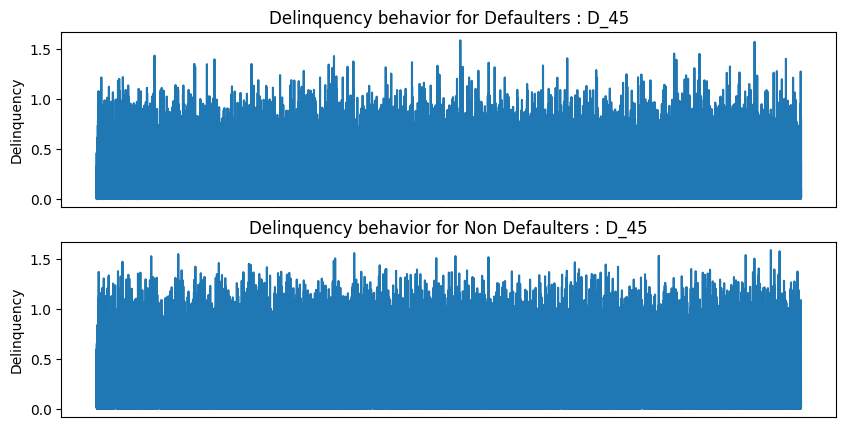

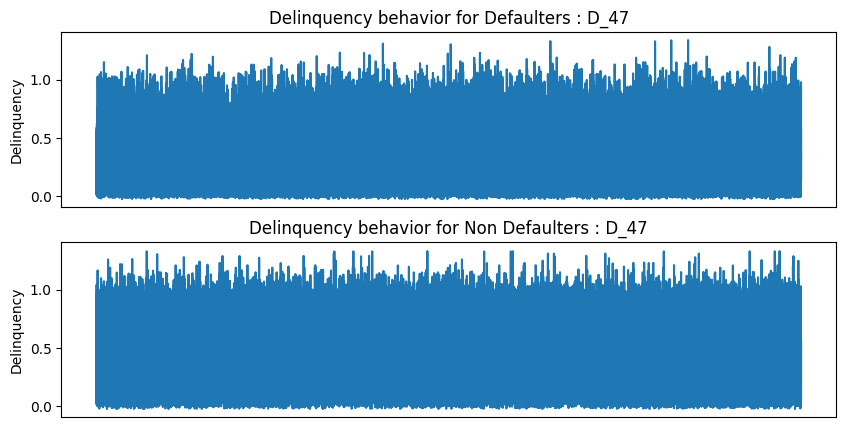

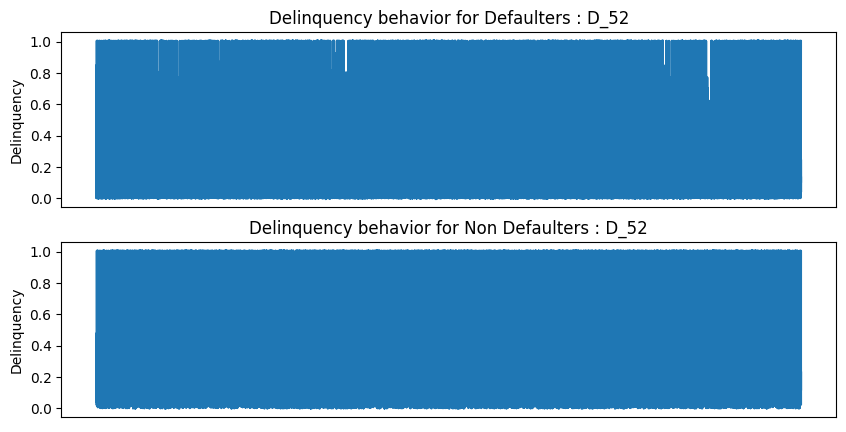

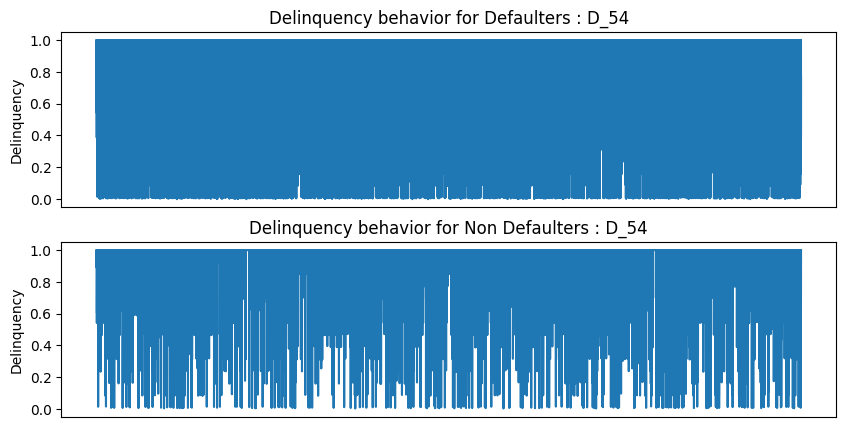

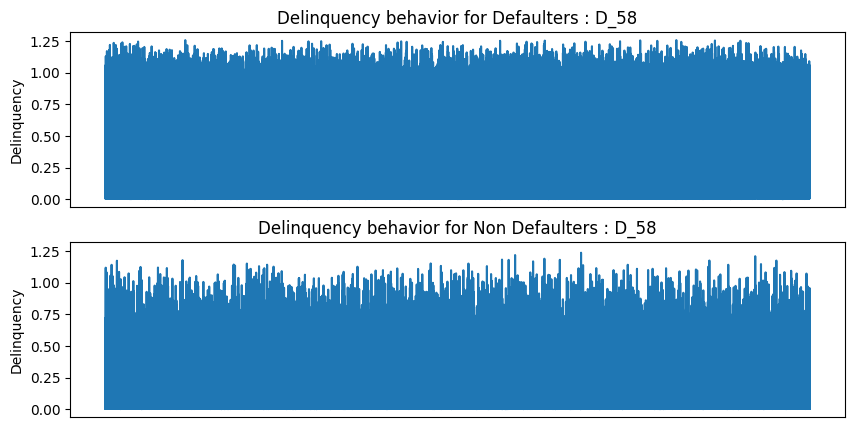

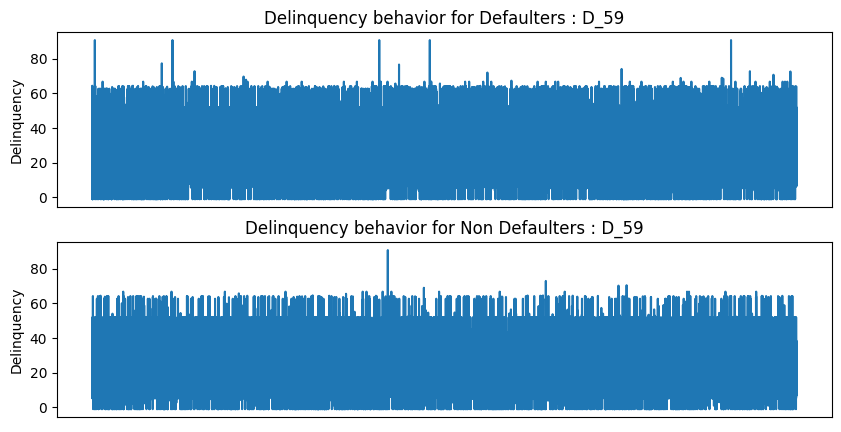

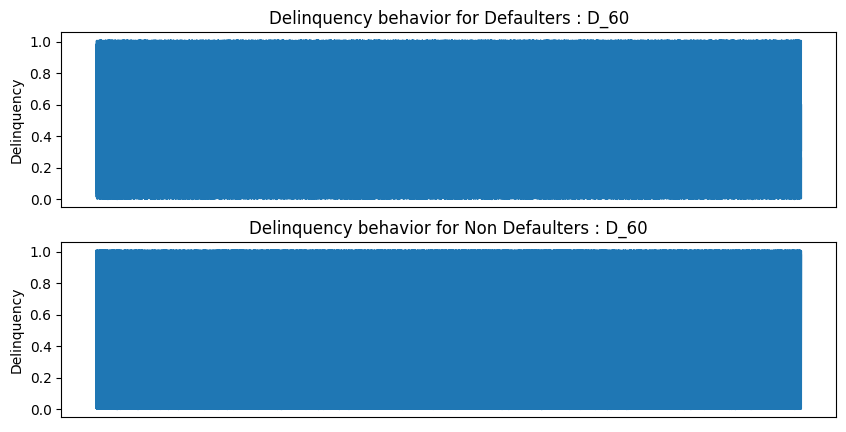

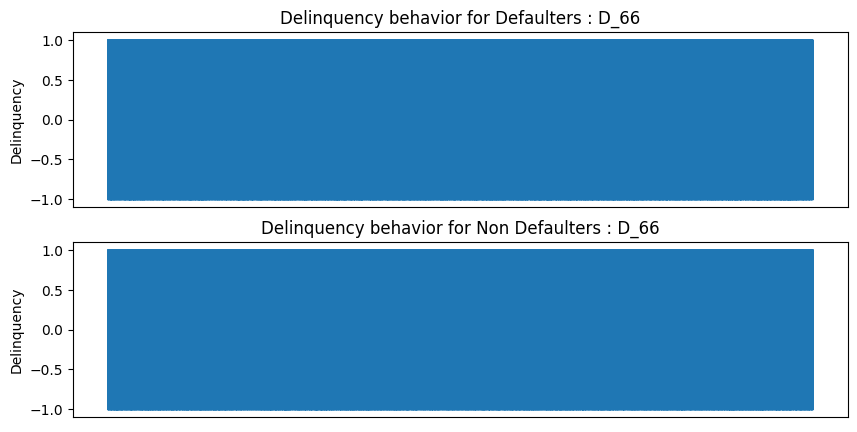

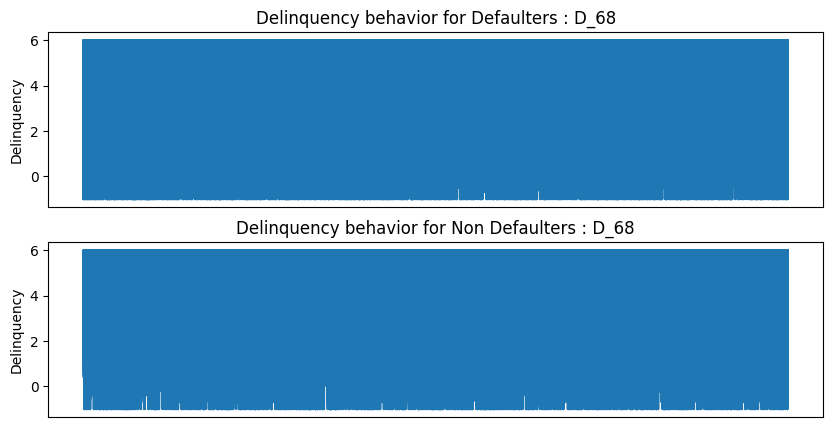

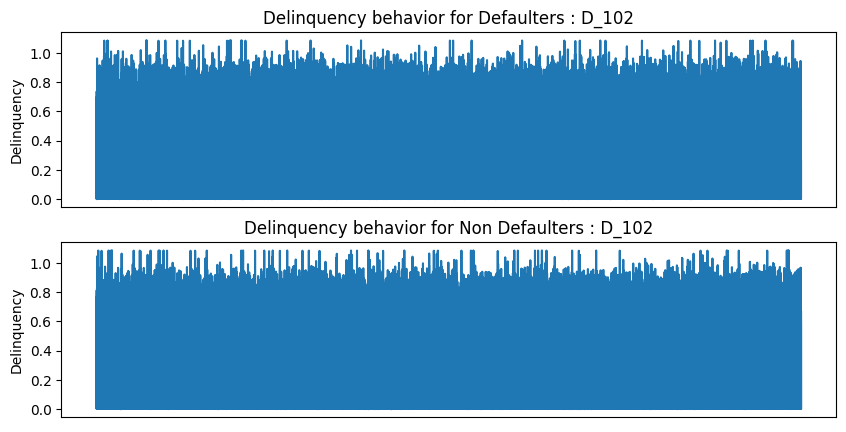

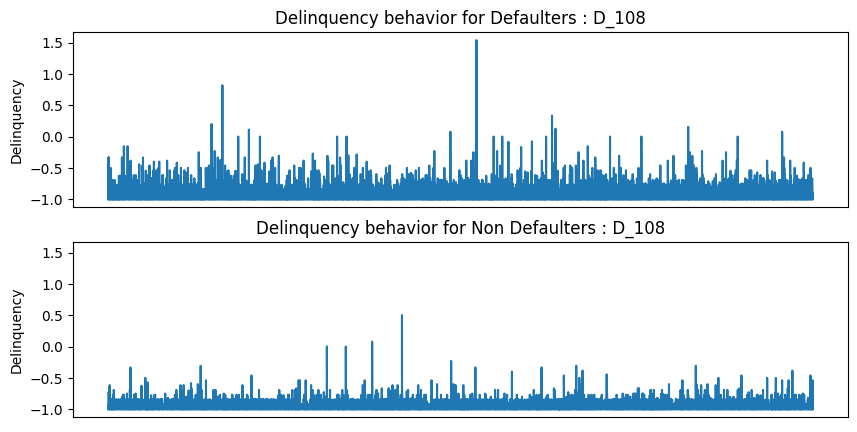

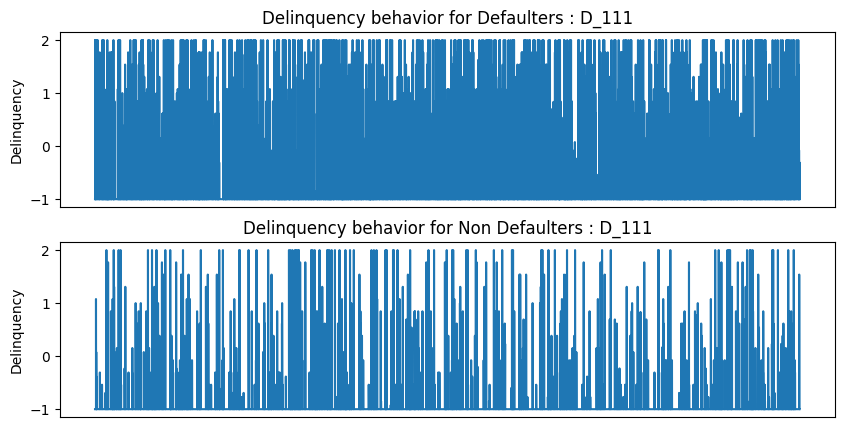

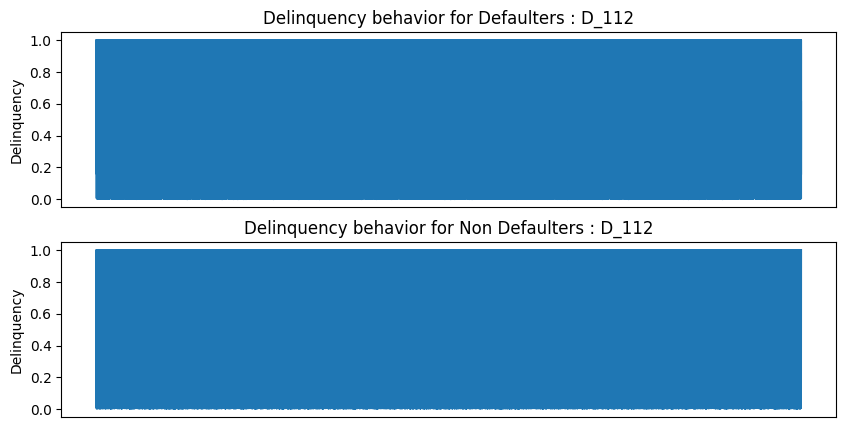

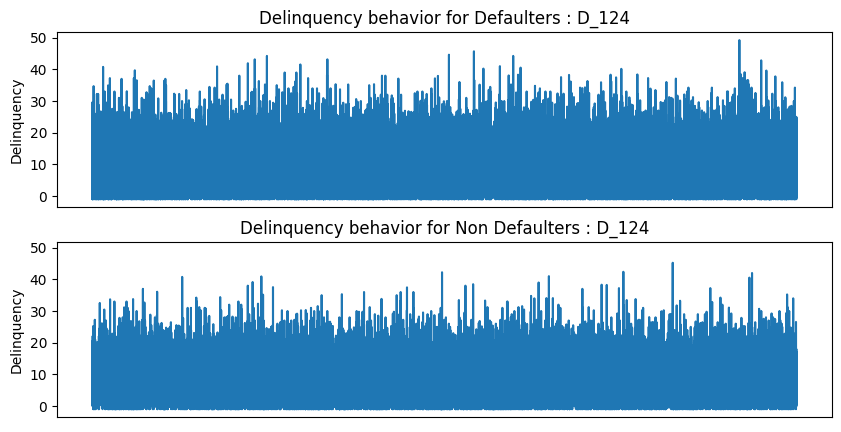

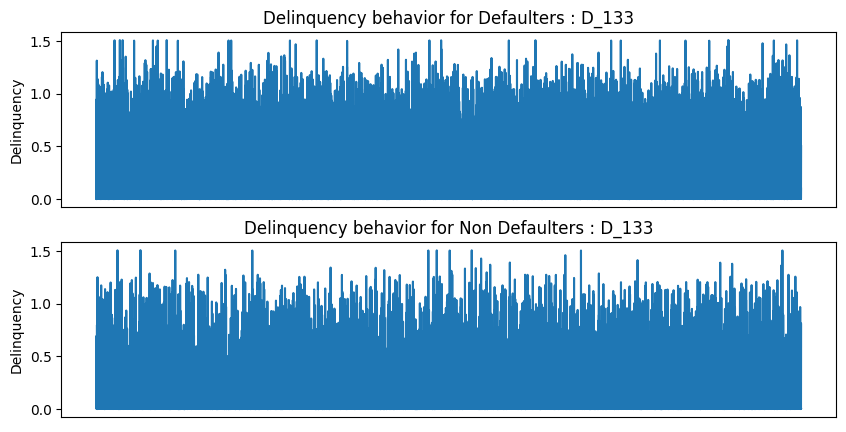

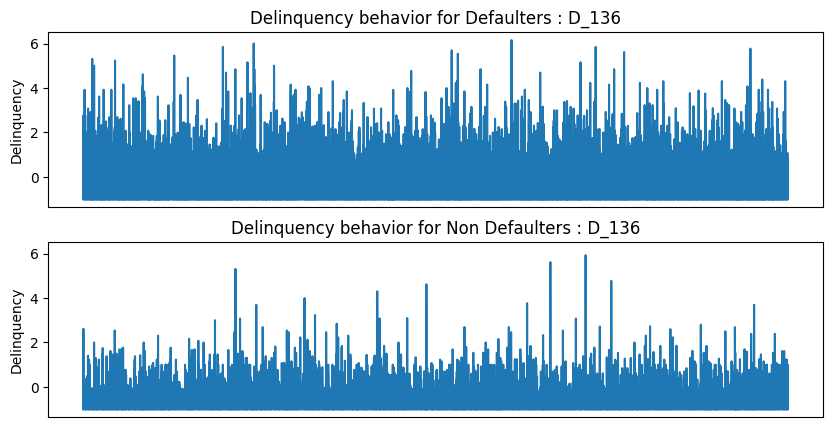

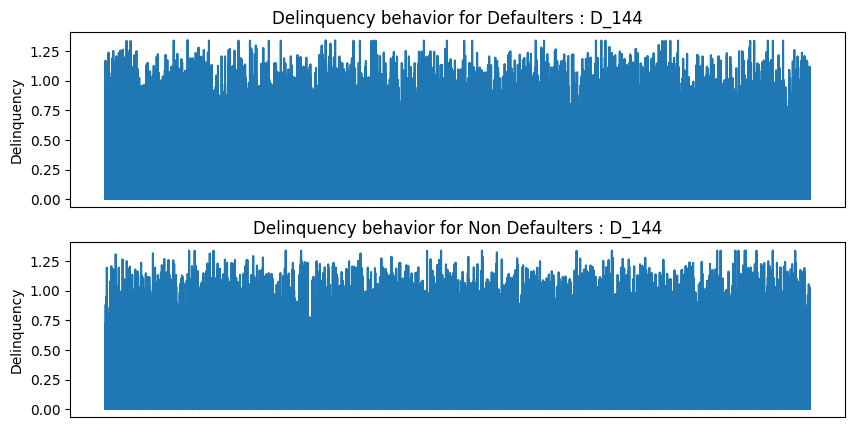

In [64]:
plot_category_behavior_comparison_mean('Delinquency', d_arr)

In [27]:
s_arr = large_dataset_reduced_cols.columns[large_dataset_reduced_cols.columns.str.startswith("S_")]
s_arr = s_arr.drop(['S_2'])
print(f"Spend variables: {s_arr}")
print(f"Spend variables length: {len(s_arr)}")

Spend variables: Index(['S_11', 'S_15', 'S_17', 'S_19', 'S_25'], dtype='object')
Spend variables length: 5


In [ ]:
plot_category_behavior_comparison_mean('Spend', s_arr)

### Studying behavior by min

In [23]:
# Grouping all rows for a customer by taking min of each column
ldrc_def_col_min = large_dataset_reduced_cols_defaulters.groupby(['customer_ID'], as_index=False).min()
ldrc_nondef_col_min = large_dataset_reduced_cols_nondefaulters.groupby(['customer_ID'], as_index=False).min()
print(f"Dimensions of reduced by column min Defaulters records: {ldrc_def_col_min.shape}")
print(f"Dimensions of reduced by column min Non-Defaulters records: {ldrc_nondef_col_min.shape}")

# Randomly selecting 100000 customers from each
rand_ldrc_def_col_min = ldrc_def_col_min.sample(n=100000)
rand_ldrc_nondef_col_min = ldrc_nondef_col_min.sample(n=100000)

Dimensions of reduced by column min Defaulters records: (118828, 45)
Dimensions of reduced by column min Non-Defaulters records: (340085, 45)


In [41]:
def plot_category_behavior_comparison_min(category, columns):
    for var in columns:
        fig, axs = plt.subplots(2, 1, figsize=(10,5), sharey=True)

        plt.subplot(2, 1, 1)
        plt.plot(rand_ldrc_def_col_min.customer_ID, rand_ldrc_def_col_min[var])

        plt.title(f"{category} behavior for Defaulters : {var}");
        plt.ylabel(category);
        axs[0].get_xaxis().set_visible(False);

        plt.subplot(2, 1, 2)
        plt.plot(rand_ldrc_nondef_col_min.customer_ID, rand_ldrc_nondef_col_min[var])

        plt.title(f"{category} behavior for Non Defaulters : {var}");
        plt.ylabel(category);
        axs[1].get_xaxis().set_visible(False);
        
        plt.savefig(f"./plots/column-min/{category}-{var}.pdf")

In [ ]:
    plot_category_behavior_comparison_min('Risk', r_arr)

In [ ]:
plot_category_behavior_comparison_min('Payment', p_arr)

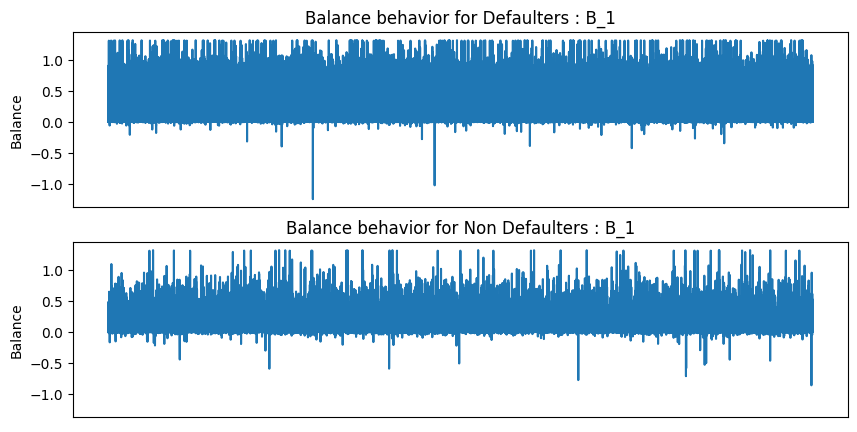

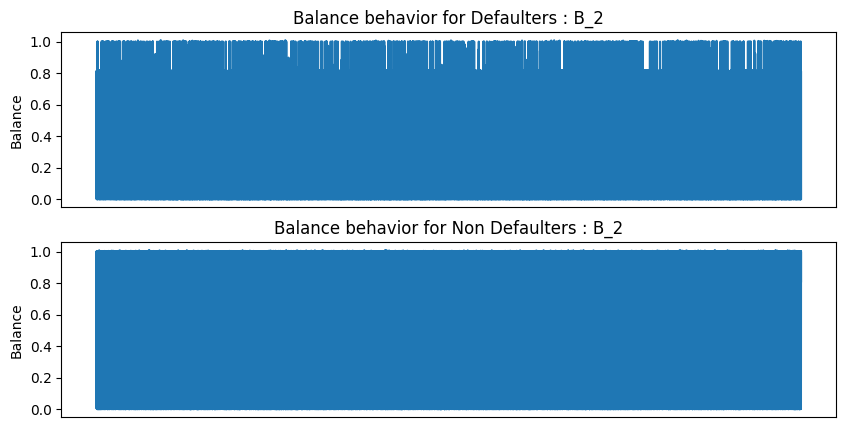

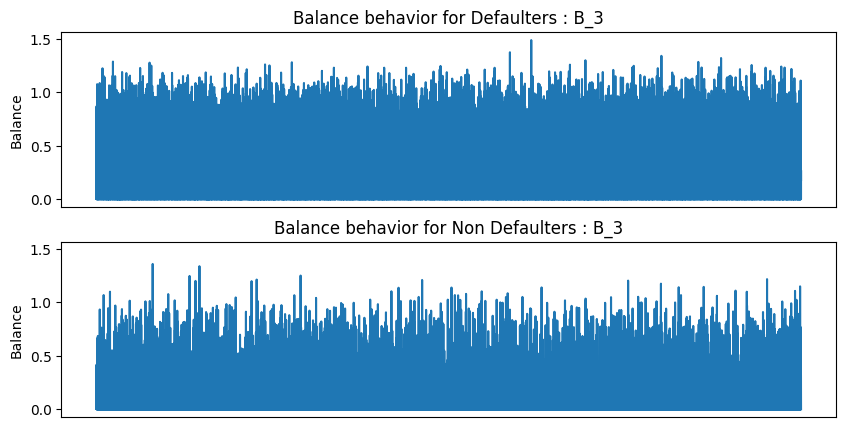

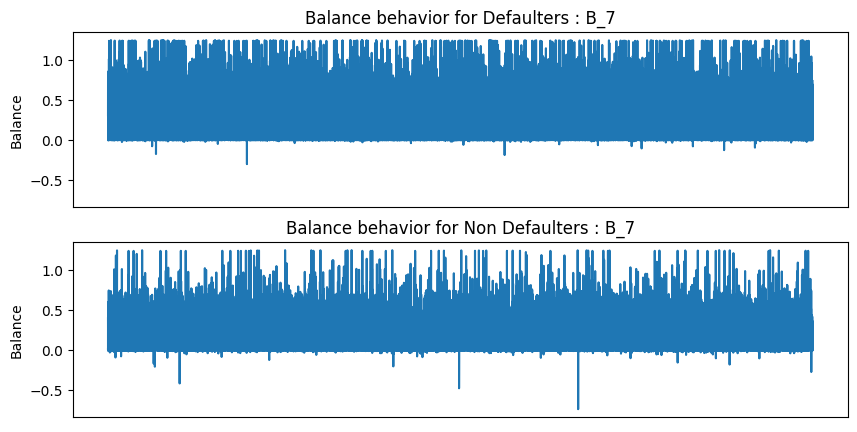

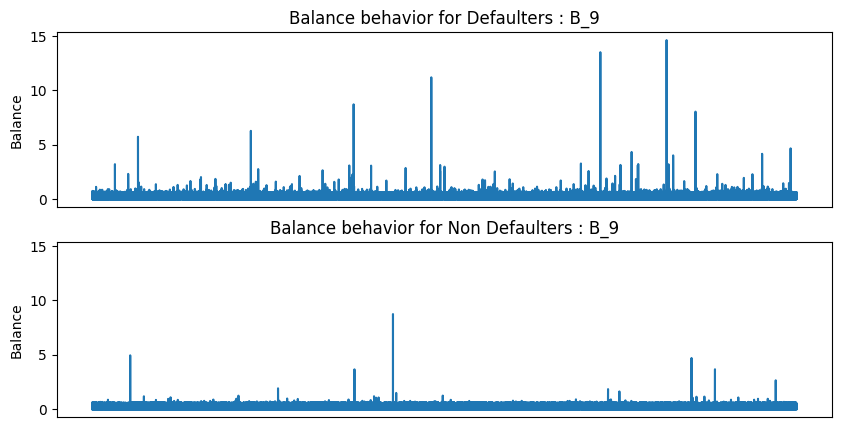

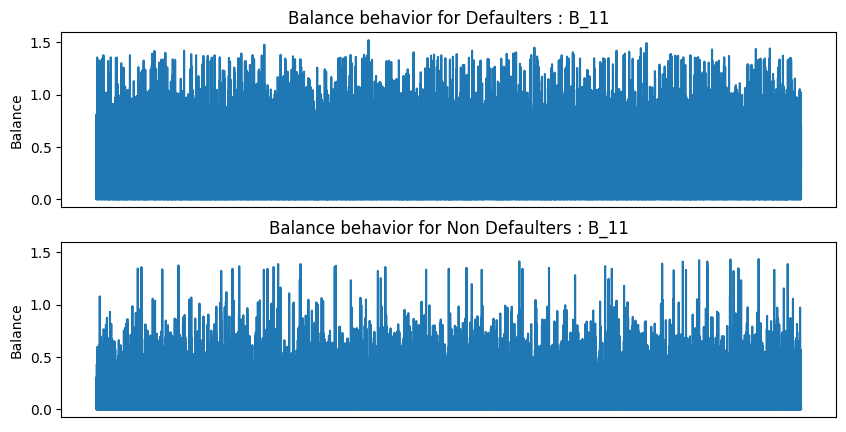

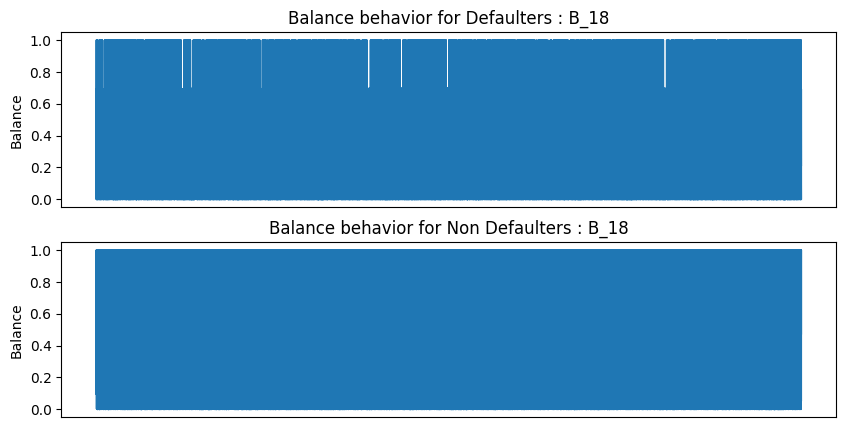

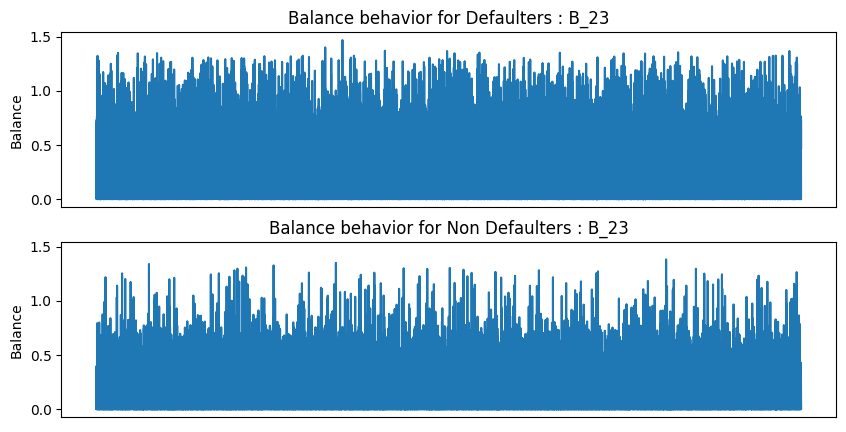

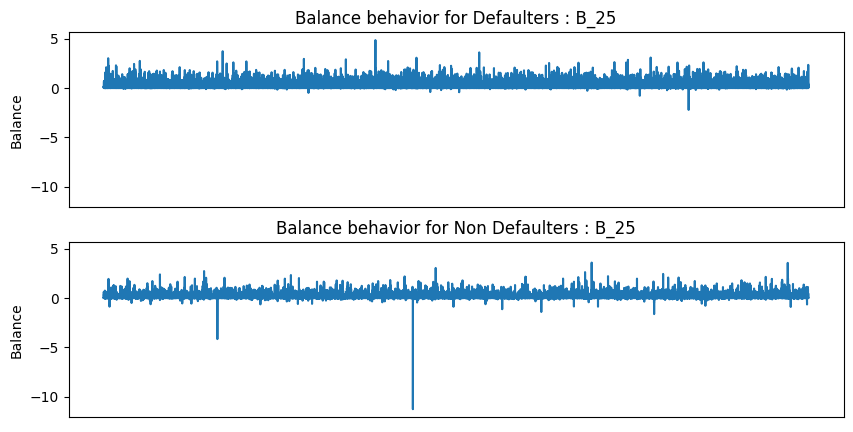

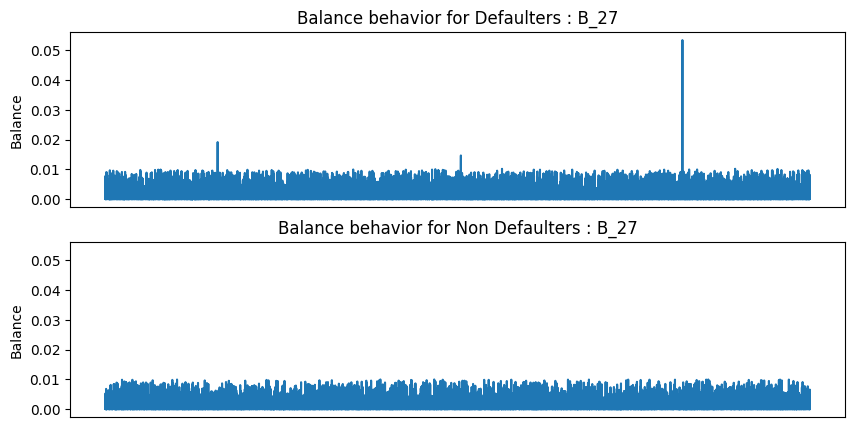

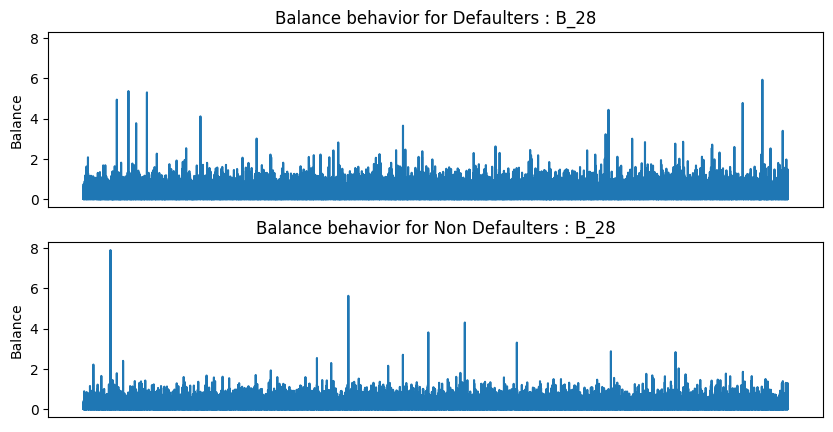

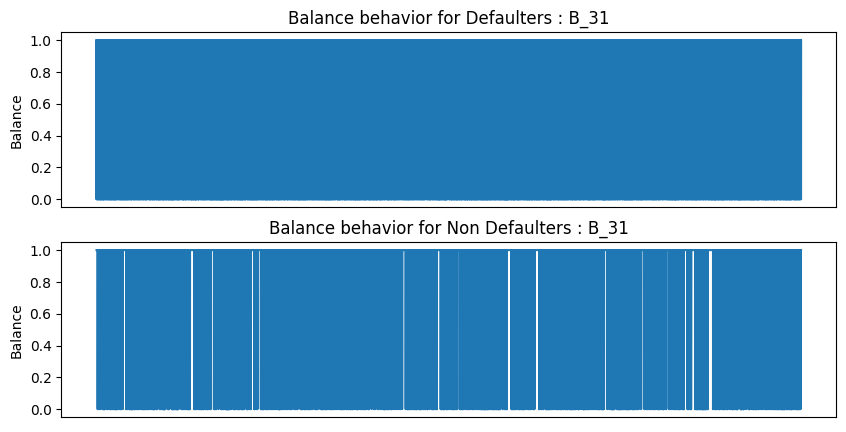

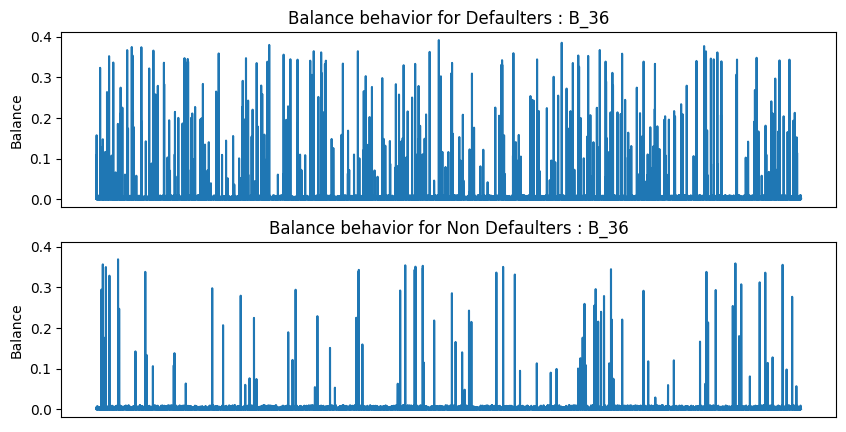

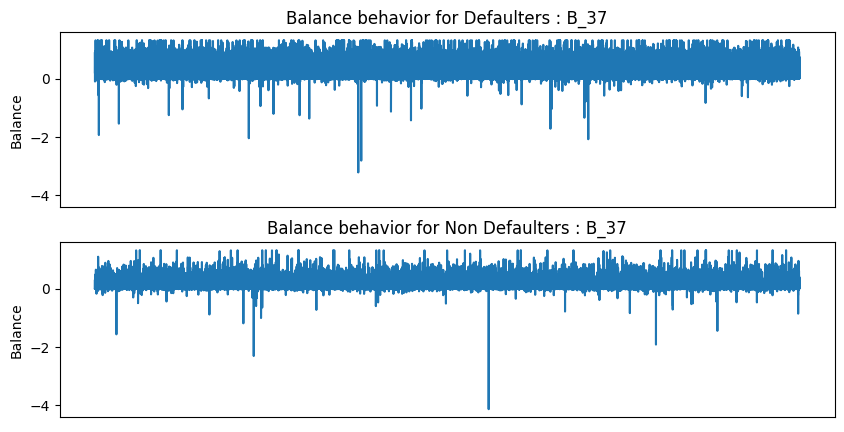

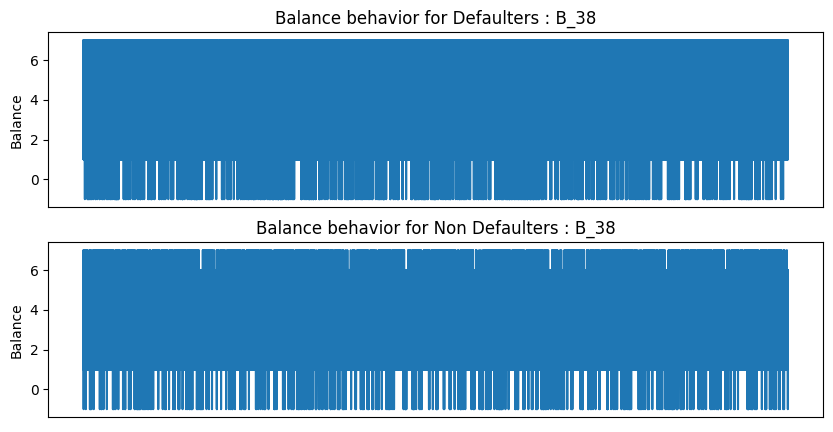

In [45]:
plot_category_behavior_comparison_min('Balance', b_arr)

In [ ]:
plot_category_behavior_comparison_min('Delinquency', d_arr)

In [ ]:
plot_category_behavior_comparison_min('Spend', s_arr)

### Studying behavior by max

In [48]:
# Grouping all rows for a customer by taking max of each column
ldrc_def_col_max = large_dataset_reduced_cols_defaulters.groupby(['customer_ID'], as_index=False).max()
ldrc_nondef_col_max = large_dataset_reduced_cols_nondefaulters.groupby(['customer_ID'], as_index=False).max()
print(f"Dimensions of reduced by column max Defaulters records: {ldrc_def_col_max.shape}")
print(f"Dimensions of reduced by column max Non-Defaulters records: {ldrc_nondef_col_max.shape}")

# Randomly selecting 100000 customers from each
rand_ldrc_def_col_max = ldrc_def_col_max.sample(n=100000)
rand_ldrc_nondef_col_max = ldrc_nondef_col_max.sample(n=100000)

Dimensions of reduced by column max Defaulters records: (118828, 45)
Dimensions of reduced by column max Non-Defaulters records: (340085, 45)


In [49]:
def plot_category_behavior_comparison_max(category, columns):
    for var in columns:
        fig, axs = plt.subplots(2, 1, figsize=(10,5), sharey=True)

        plt.subplot(2, 1, 1)
        plt.plot(rand_ldrc_def_col_max.customer_ID, rand_ldrc_def_col_max[var])

        plt.title(f"{category} behavior for Defaulters : {var}");
        plt.ylabel(category);
        axs[0].get_xaxis().set_visible(False);

        plt.subplot(2, 1, 2)
        plt.plot(rand_ldrc_nondef_col_max.customer_ID, rand_ldrc_nondef_col_max[var])

        plt.title(f"{category} behavior for Non Defaulters : {var}");
        plt.ylabel(category);
        axs[1].get_xaxis().set_visible(False);
        
        plt.savefig(f"./plots/column-max/{category}-{var}.pdf")

In [ ]:
plot_category_behavior_comparison_max('Risk', r_arr)

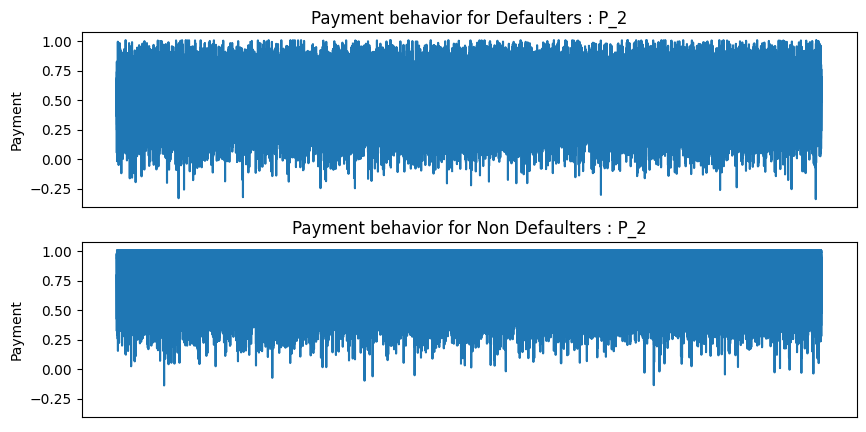

In [52]:
plot_category_behavior_comparison_max('Payment', p_arr)

In [ ]:
plot_category_behavior_comparison_max('Balance', b_arr)

In [ ]:
plot_category_behavior_comparison_max('Delinquency', d_arr)

In [ ]:
plot_category_behavior_comparison_max('Spend', s_arr)

### Summary columns not alerted by Pandas profiler

Based on the above analysis of columns not flagged for any issues by Pandas profiler, the following columns don't seem to very useful and can be safely dropped without much information loss.

‘R_9’, 'B_1', 'B_2', 'B_7', 'B_18', 'B_25', 'B_28', 'B_37', 'P_2', 'D_47 ', 'D_52 ', 'D_60 ', 'D_66 ', 'D_68', 'D_102 ', 'D_112 ', 'D_124 ', 'D_144', 'S_11’

## Data Preprocessing

In [139]:
# Redescribe the dataframe used for profiling
large_dataset.shape

(5531451, 191)

In [140]:
# Drop all columns alerted by Pandas except the ones identified in EDA to be retained
alerted_cols = ['customer_ID','S_2','D_42','S_3','D_43','D_46','D_48','D_50','P_3','D_53','S_7','D_55','D_56','S_9','D_61','D_62','B_17','D_69','D_73','D_76','D_77','B_29','D_88','D_104','D_105','R_27','D_110','B_39','S_27','D_115','D_118','D_119','D_121','D_128','B_42','D_130','D_131','D_132','D_134','D_141','D_142','B_5','D_49','B_6','D_50','B_10','S_5','B_12','B_13','B_14','D_61','B_15','D_65','S_12','B_21','D_69','D_71','B_24','R_7','B_26','S_16','R_13','R_14','D_87','R_17','R_18','R_20','R_23','S_22','S_23','S_24','S_26','D_106','R_26','B_40','D_123','R_28','D_39','D_41','D_44','B_4','R_2','B_8','D_51','R_3','S_6','R_4','S_8','R_5','D_63','D_64','D_65','B_16','B_19','B_20','S_13','B_22','D_70','D_72','P_4','D_74','D_75','R_7','D_78','D_79','R_8','D_80','R_10','R_11','D_81','D_82','R_13','D_83','R_14','R_15','D_84','R_16','B_30','S_18','D_86','R_17','R_18','R_19','B_32','S_20','R_20','R_21','B_33','D_89','R_22','R_23','D_91','D_92','D_93','D_94','R_24','R_25','D_96','D_103','D_104','D_106','D_107','R_26','D_109','D_113','D_114','D_116','D_117','D_120','D_122','D_123','D_125','D_126','D_127','D_128','D_129','B_41','D_130','D_131','R_28','D_135','D_137','D_138','D_139','D_140','D_141','D_143','D_145','target']
print(f"Length of alerted columns: {len(alerted_cols)}")
retain_alerted_cols = ['customer_ID', 'S_2', 'P_3', 'D_55', 'D_104', 'R_27', 'D_115', 'D_118', 'D_119', 'D_121', 'D_128', 'D_61', 'S_22', 'S_23', 'S_24', 'B_40', 'B_30', 'B_38', 'D_117', 'D_120', 'D_64', 'D_68', 'D_82', 'D_122', 'target']
print(f"Length of columns to retain: {len(retain_alerted_cols)}")
alerted_cols_drop = [ele for ele in alerted_cols if ele not in retain_alerted_cols]
print(f"Length of alerted columns to drop: {len(alerted_cols_drop)}")

reduced_alerted_df = large_dataset.drop(alerted_cols_drop, axis=1)
print(f"Shape after removing alerted columns: {reduced_alerted_df.shape}")

Length of alerted columns: 169
Length of columns to retain: 25
Length of alerted columns to drop: 143
Shape after removing alerted columns: (5531451, 65)


In [141]:
reduced_alerted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 65 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_ID  object 
 1   S_2          object 
 2   P_2          float32
 3   B_1          float32
 4   B_2          float32
 5   R_1          float32
 6   B_3          float32
 7   D_45         float32
 8   D_47         float32
 9   B_7          float32
 10  B_9          float32
 11  D_52         float32
 12  P_3          float32
 13  B_11         float32
 14  D_54         float32
 15  D_55         float32
 16  D_58         float32
 17  D_59         int8   
 18  D_60         float32
 19  D_61         float32
 20  S_11         int8   
 21  D_64         int8   
 22  B_18         float32
 23  D_66         int8   
 24  D_68         int8   
 25  R_6          float32
 26  S_15         int8   
 27  B_23         float32
 28  B_25         float32
 29  R_9          int8   
 30  B_27         float32
 31  D_82         int8   
 32

In [142]:
# Drop all columns providing less info to be dropped
non_alerted_cols_drop = ['R_9', 'B_1', 'B_2', 'B_7', 'B_18', 'B_25', 'B_28', 'B_37', 'P_2', 'D_47', 'D_52', 'D_60', 'D_66', 'D_68', 'D_102', 'D_112', 'D_124', 'D_144', 'S_11']
print(f"Length of non alerted columns to drop: {len(non_alerted_cols_drop)}")

reduced_cols_df = reduced_alerted_df.drop(non_alerted_cols_drop, axis=1)
print(f"Shape after removing less useful columns: {reduced_cols_df.shape}")

Length of non alerted columns to drop: 19
Shape after removing less useful columns: (5531451, 46)


In [143]:
retained_skewed_columns = ['D_61', 'S_22', 'S_23', 'S_24', 'B_40']

In [144]:
reduced_cols_df[retained_skewed_columns].isnull().sum()

D_61    598052
S_22     19024
S_23       445
S_24     18593
B_40        53
dtype: int64

In [145]:
reduced_cols_df[retained_skewed_columns].describe()

D_61          S_22          S_23          S_24          B_40
count  4.933399e+06  5.512427e+06  5.531006e+06  5.512858e+06  5.531398e+06
mean   4.296289e-01  7.791036e-01  1.796775e-01  7.349204e-01  2.032608e-01
std    5.245269e-01  7.187471e-01  8.519580e-01  8.356727e-01  8.081345e+00
min   -9.259018e-03 -9.199815e+01 -2.060855e+02 -9.048383e+01  1.201275e-08
25%    9.247558e-02  8.111972e-01  1.334254e-01  8.094516e-01  1.739309e-02
50%    3.722664e-01  9.422135e-01  1.362231e-01  9.493249e-01  5.830858e-02
75%    7.745240e-01  9.647727e-01  1.390174e-01  9.715760e-01  2.451545e-01
max    8.685154e+02  1.032727e+00  8.853349e+02  1.055638e+00  5.755076e+03

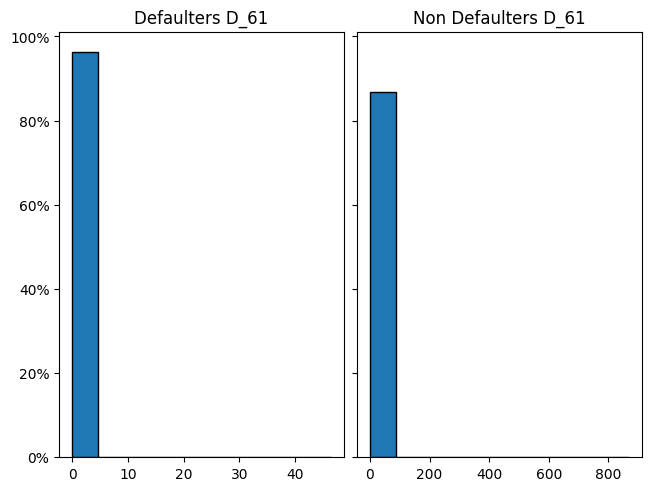

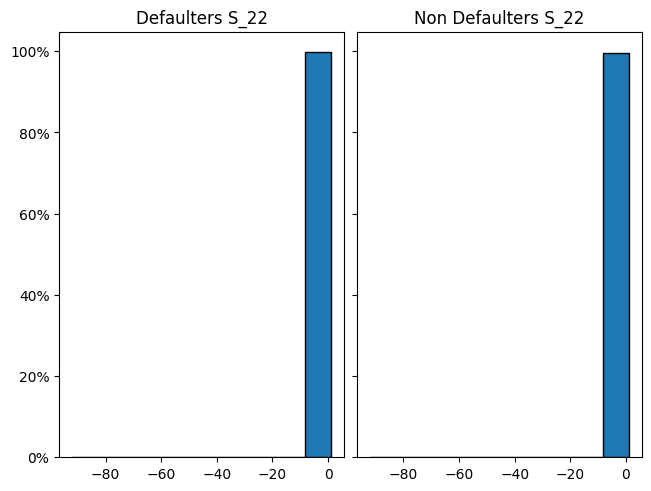

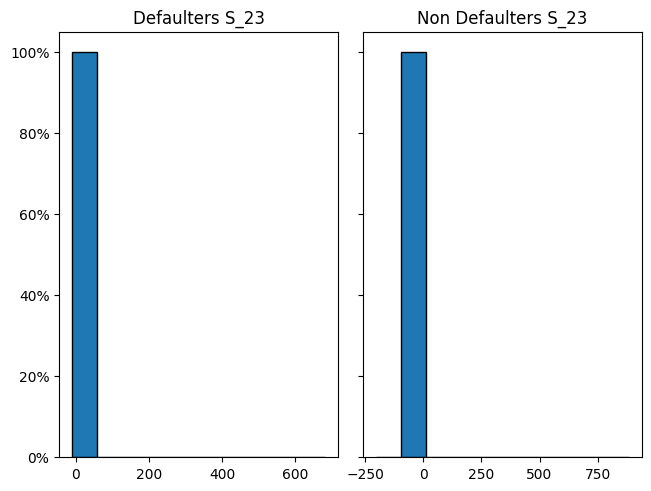

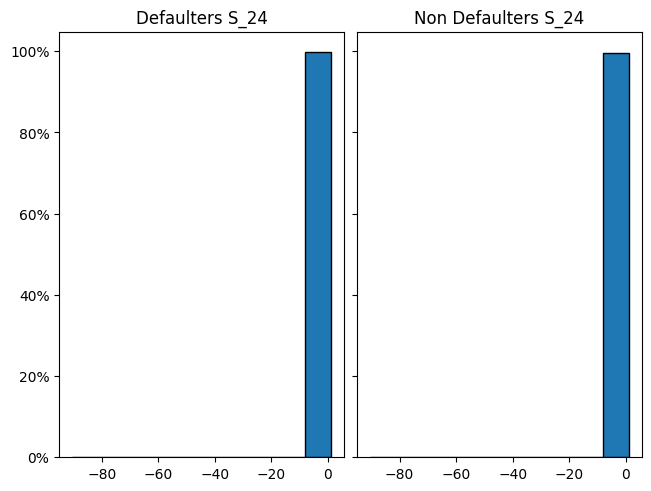

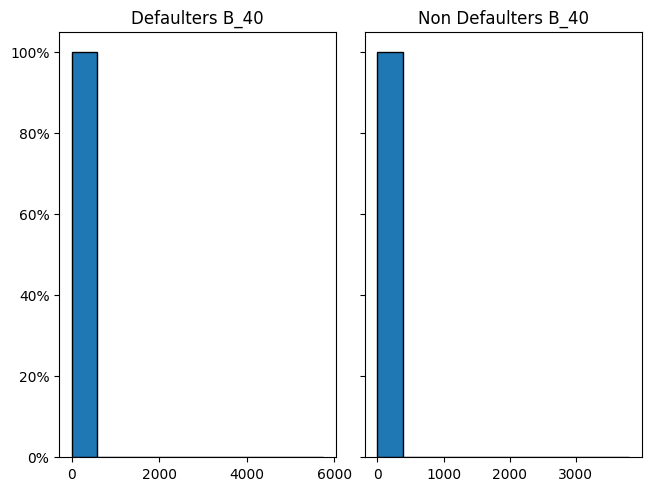

In [146]:
plot_histogram_grouped_by_target(reduced_cols_df, retained_skewed_columns)

In [162]:
def winsorize_with_pandas(skewed_columns):
    temp_df = reduced_cols_df.copy(deep=True)
    for col in skewed_columns:
        s = temp_df[col]
        q_low = s.quantile(0.01)
        q_hi  = s.quantile(0.99)
        print(f"{col} {q_low} {q_hi}")
        temp_df[col] = s.clip(lower=s.quantile(0.01, interpolation='lower'), 
                  upper=s.quantile(0.99, interpolation='higher'))
    return temp_df

In [198]:
df_without_outliers = winsorize_with_pandas(retained_skewed_columns)

D_61 0.0005983115988783538 1.0050994157791138
S_22 0.009235554374754429 1.0053942203521729
S_23 0.004983941558748484 1.0051124095916748
S_24 0.005140724126249552 1.0054935216903687
B_40 0.0007085422403179109 1.0051589012145996


In [150]:
df_without_outliers[retained_skewed_columns].describe()

D_61          S_22          S_23          S_24          B_40
count  4.933399e+06  5.512427e+06  5.531006e+06  5.512858e+06  5.531398e+06
mean   4.277027e-01  7.873040e-01  1.751385e-01  7.443009e-01  1.658736e-01
std    3.355655e-01  2.881681e-01  1.532216e-01  3.727011e-01  2.164768e-01
min    5.982825e-04  9.235530e-03  4.983363e-03  5.140589e-03  7.085392e-04
25%    9.247558e-02  8.111972e-01  1.334254e-01  8.094516e-01  1.739309e-02
50%    3.722664e-01  9.422135e-01  1.362231e-01  9.493249e-01  5.830858e-02
75%    7.745240e-01  9.647727e-01  1.390174e-01  9.715760e-01  2.451545e-01
max    1.005103e+00  1.005394e+00  1.005113e+00  1.005494e+00  1.005165e+00

In [ ]:
df_without_outliers[retained_skewed_columns].isnull().sum()

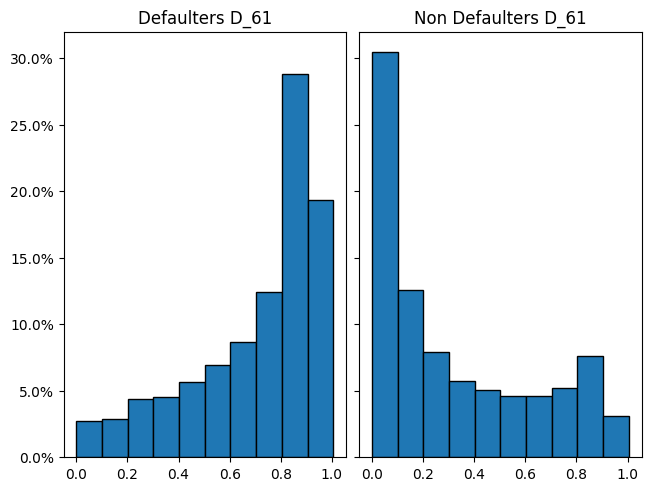

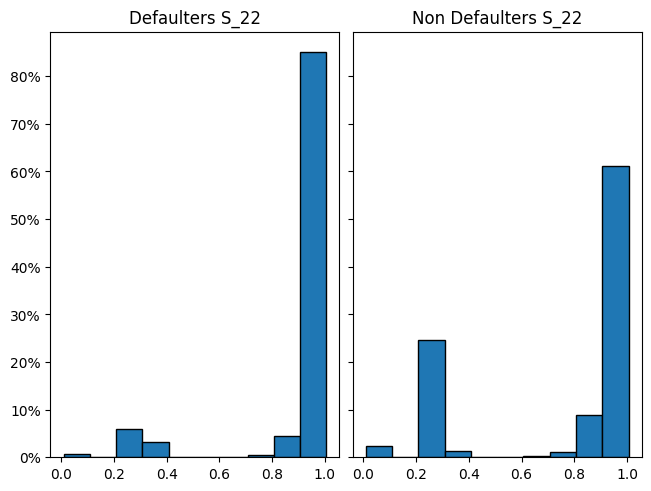

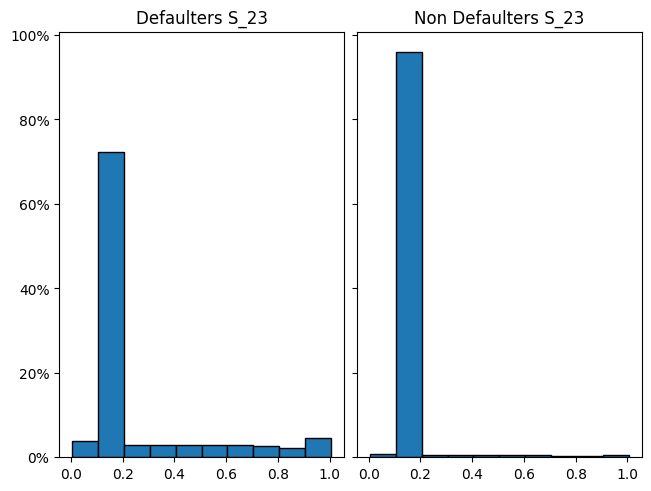

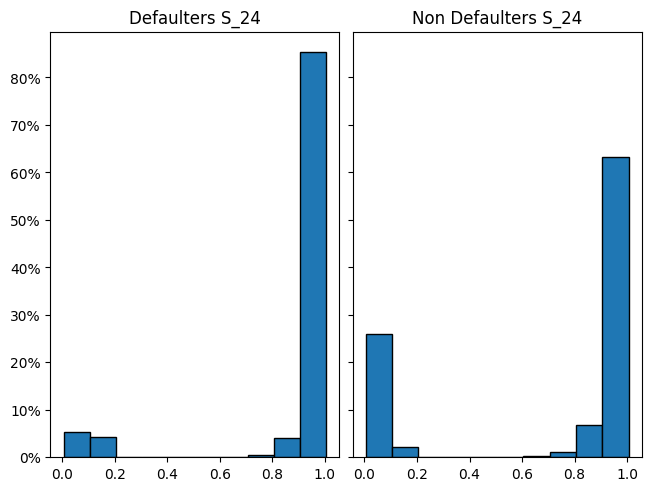

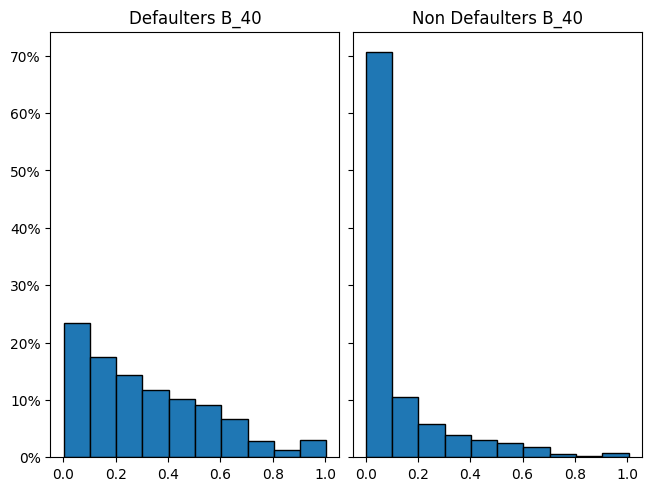

In [152]:
plot_histogram_grouped_by_target(df_without_outliers, retained_skewed_columns)

In [200]:
def customer_monthly_profile(df):
    pd.set_option('display.max_colwidth', None)
    reporting_month = (df['S_2']).str.slice(5, 7)
    concatenated_value = df['customer_ID']+reporting_month
    
    from pandas.util import hash_pandas_object
    hashed_concatenated_values = hash_pandas_object(concatenated_value, index=False)

    hashed_concatenated_values = 1.0 - (hashed_concatenated_values / hashed_concatenated_values.max())
    df.insert(2, "CID_month", hashed_concatenated_values)
    return df

In [201]:
df = customer_monthly_profile(df_without_outliers)

In [203]:
df.head(30)

customer_ID  \
0   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
1   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
2   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
3   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
4   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
5   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
6   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
7   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
8   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
9   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
10  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
11  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
12  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a   
13  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
14  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
15  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
16  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
17  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
18  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
19  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
20  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
21  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
22  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
23  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
24  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
25  00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5   
26  00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1   
27  00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1   
28  00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1   
29  00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1   

           S_2  CID_month       R_1       B_3      D_45       B_9       P_3  \
0   2017-03-09   0.178715  0.009228  0.004709  0.708906  0.008207  0.736463   
1   2017-04-07   0.598991  0.006151  0.002714  0.712795  0.008373  0.720886   
2   2017-05-28   0.614565  0.006815  0.009423  0.720884  0.009355  0.738044   
3   2017-06-13   0.083225  0.001373  0.005531  0.723997  0.006782  0.741813   
4   2017-07-16   0.115620  0.007605  0.009312  0.720619  0.000519  0.691986   
5   2017-08-04   0.169169  0.004220  0.009866  0.721371  0.007123  0.676528   
6   2017-09-18   0.153551  0.004509  0.000783  0.721725  0.008208  0.680102   
7   2017-10-08   0.755252  0.000263  0.007836  0.723293  0.001077  0.609996   
8   2017-11-20   0.035623  0.001789  0.009817  0.730918  0.006822  0.697672   
9   2017-12-04   0.291397  0.001772  0.006073  0.735001  0.007081  0.689886   
10  2018-01-11   0.632381  0.008175  0.003238  0.730121  0.006717  0.581678   
11  2018-02-21   0.748958  0.000607  0.007454  0.740062  0.001064  0.647352   
12  2018-03-13   0.178715  0.006104  0.007174  0.740102  0.009535  0.629392   
13  2017-03-01   0.018010  0.005515  0.005830  0.239459  0.007561  0.619012   
14  2017-04-16   0.991782  0.003287  0.000861  0.247009  0.004459  0.591144   
15  2017-05-07   0.982493  0.005594  0.010466  0.243068  0.010246  0.597797   
16  2017-06-25   0.939735  0.008996  0.005360  0.254167  0.010398  0.610274   
17  2017-07-30   0.163635  0.008041  0.005484  0.248585  0.045093  0.566030   
18  2017-08-19   0.313372  0.007448  0.003697  0.259658  0.001722  0.563508   
19  2017-09-15   0.033076  0.007054  0.005417  0.261886  0.001970  0.573885   
20  2017-10-20   0.955090  0.006165  0.012861  0.258513  0.005092  0.596216   
21  2017-11-24   0.761604  0.001023  0.001811  0.258391  0.006527  0.510142   
22  201

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 47 columns):
 #   Column       Dtype         
---  ------       -----         
 0   customer_ID  object        
 1   S_2          datetime64[ns]
 2   CID_month    float64       
 3   R_1          float32       
 4   B_3          float32       
 5   D_45         float32       
 6   B_9          float32       
 7   P_3          float32       
 8   B_11         float32       
 9   D_54         float32       
 10  D_55         float32       
 11  D_58         float32       
 12  D_59         int8          
 13  D_61         float32       
 14  D_64         int8          
 15  R_6          float32       
 16  S_15         int8          
 17  B_23         float32       
 18  B_27         float32       
 19  D_82         int8          
 20  S_17         float32       
 21  R_12         float32       
 22  B_30         int8          
 23  B_31         int8          
 24  S_19         float32    

### Sampling data

In [204]:
df_defaulters = df[(df.target == 1)]

In [205]:
df_non_defaulters = df[(df.target == 0)]

In [206]:
df_train = pd.concat([df_defaulters.head(45500), df_non_defaulters.head(45500)], ignore_index=True)
df_train.shape

(91000, 47)

In [208]:
df_remaining = pd.concat([df_defaulters.tail(1332369), df_non_defaulters.tail(4108082)], ignore_index=True)
df_remaining.shape

(5440451, 47)

In [209]:
df_remaining_sampled = df_remaining.sample(n=20000)
df_remaining_sampled.shape

(20000, 47)

In [210]:
from sklearn.model_selection import train_test_split
df_valid, df_test = train_test_split(df_remaining_sampled, test_size=0.3)

In [212]:
print(f"Train size: {df_train.shape}")
print(f"Validation size: {df_valid.shape}")
print(f"Test size: {df_test.shape}")

Train size: (91000, 47)
Validation size: (14000, 47)
Test size: (6000, 47)


In [214]:
df_train.target.value_counts()

1    45500
0    45500
Name: target, dtype: int64

In [215]:
df_valid.target.value_counts()

0    10563
1     3437
Name: target, dtype: int64

In [216]:
df_test.target.value_counts()

0    4500
1    1500
Name: target, dtype: int64

In [223]:
df_valid.customer_ID.value_counts()

6644efa2376b5b87c14087ee43dd8b52c4e566cfdea537b4933a7b895ab5e4ec    3
8fb793cd2fa215fbffe4538f7ea248461f7a0b4870b36308c58eef63ed5cbdda    2
9a2c66a703eca3cd9c781ca190d71c76570430bd11206b46c9b9542d970e6d98    2
3dd153e1a812a50bb6b6502ec7aa04492b54d069574660217c7969076056bb1d    2
1bed0861f243890c1a026fe75bc66eac48e780106161329b5228c4542cc1fbcf    2
                                                                   ..
fc3c9140537d4a09a9c30de9c51fe150a937192343fb461120f11bae0669b327    1
558dc8bc211886b7799f84774c6f432dc8ae90cbfbf9e20c217791098b797c0e    1
e128a280f8c10b70f37803d1cca8eeb81a0b41d394f38d38d506f491a3e3ca3a    1
344dd2e4dadd7434311be955f90c090914e0b050a8b978193586065fe40af4fa    1
3da51fc12e03148e2b671e0b1a2e8d8d30c3b38e13b12bcf8d2aede876b66a16    1
Name: customer_ID, Length: 13791, dtype: int64

In [225]:
df_train.to_csv('Final-Capstone-Data/train.csv', index=None)
df_valid.to_csv('Final-Capstone-Data/valid.csv', index=None)
df_test.to_csv('Final-Capstone-Data/test.csv', index=None)

In [226]:
plt.close('all')

## Model

In [252]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91000 entries, 0 to 90999
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_ID  91000 non-null  object 
 1   S_2          91000 non-null  object 
 2   CID_month    91000 non-null  float64
 3   R_1          91000 non-null  float32
 4   B_3          90965 non-null  float32
 5   D_45         90965 non-null  float32
 6   B_9          91000 non-null  float32
 7   P_3          84685 non-null  float32
 8   B_11         91000 non-null  float32
 9   D_54         90965 non-null  float32
 10  D_55         88302 non-null  float32
 11  D_58         91000 non-null  float32
 12  D_59         91000 non-null  int8   
 13  D_61         83234 non-null  float32
 14  D_64         91000 non-null  int8   
 15  R_6          91000 non-null  float32
 16  S_15         91000 non-null  int8   
 17  B_23         91000 non-null  float32
 18  B_27         90965 non-null  float32
 19  D_82

In [273]:
def impute_df_cols(df):
    from sklearn.impute import SimpleImputer
    if (df is not None):
        df.iloc[:, 0:47] = my_imputer.fit_transform(df.iloc[:, 0:47])  
    return df

In [274]:
x_train = df_train.drop(['customer_ID', 'S_2', 'target'], axis=1)
y_train = df_train['target']

x_test = df_test.drop(['customer_ID', 'S_2', 'target'], axis=1)
y_test = df_test['target']

In [ ]:
x_train_imputed = impute_df_cols(x_train)

In [ ]:
x_test_imputed = impute_df_cols(x_test)

In [283]:
from sklearn.linear_model import LogisticRegression

def score_dataset(X_train, l_train, X_test_temp, y_test_temp):
    # define class weights ( using best weights identified so far)
    w = {0:18, 1:180}
    print(w)
    model = LogisticRegression(penalty='l2', solver='sag', random_state=0, 
                               class_weight=w, max_iter=800)
    print("Starting model fit")
    model.fit(X_train, l_train)
    print("Starting model score for train")
    train_score = model.score(X_train, l_train)
    print("Starting model score for test")
    test_score = model.score(X_test_temp, y_test_temp)
    return model, train_score, test_score

In [ ]:
model, train_score, test_score = score_dataset(x_train, y_train, x_test, y_test)
print(f"Training score is: {train_score}")
print(f"Test score is: {test_score}")

In [285]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, f1_score
# test
l_pred = model.predict(x_test)
print(np. unique(y_test))
acc = accuracy_score(y_test,l_pred)
rec = recall_score(y_test,l_pred)
# performance
print(f'Accuracy Score: {acc}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, l_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, l_pred)}')
print(f'Recall score: {rec}')
print(f'F1 score: {f1_score(y_test,l_pred)}')

[0 1]
Accuracy Score: 0.7928333333333333
Confusion Matrix: 
[[3376 1124]
 [ 119 1381]]
Area Under Curve: 0.8354444444444443
Recall score: 0.9206666666666666
F1 score: 0.6896379525593009


Todo:
1. Create rel freq graph for proper comparison (Done)
2. Check s = large_dataset[category_cols[0]].value_counts(normalize=True) (Skipped)
3. Check https://www.statology.org/matplotlib-relative-frequency-histogram/ (Done)
4. Check https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html